# Etape 2 : Transformation des données - Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
db_path = "C:\\Users\\beche\\Documents\\Formation\\Projet5\\olist.db" #Chemin vers la base de données SQLite
conn = sqlite3.connect(db_path)# Établit une connexion à la base de données.

In [3]:
# Visualiser les tables
query_tables = """
SELECT name FROM sqlite_master WHERE type='table';
"""
tables = pd.read_sql(query_tables, conn)
print("Tables disponibles dans la base de données :")
print(tables)

Tables disponibles dans la base de données :
            name
0      customers
1         geoloc
2    order_items
3    order_pymts
4  order_reviews
5         orders
6       products
7        sellers
8    translation


Connexion à la base de données SQLite contenant les données e-commerce. Le chemin est configuré pour accéder au fichier local.

In [4]:
# Importe toutes les tables depuis la base SQLite vers des DataFrames pandas pour faciliter leur manipulation et analyse.
customers_df = pd.read_sql("SELECT * FROM customers", conn)
orders_df = pd.read_sql("SELECT * FROM orders", conn)
order_items_df = pd.read_sql("SELECT * FROM order_items", conn)
order_payments_df = pd.read_sql("SELECT * FROM order_pymts", conn)
order_reviews_df = pd.read_sql("SELECT * FROM order_reviews", conn)
products_df = pd.read_sql("SELECT * FROM products", conn)
sellers_df = pd.read_sql("SELECT * FROM sellers", conn)
geoloc_df = pd.read_sql("SELECT * FROM geoloc", conn)
translation_df = pd.read_sql("SELECT * FROM translation", conn)

Import de toutes les tables depuis la base SQLite vers des DataFrames pandas pour permettre leur manipulation et analyse. Chaque table est chargée individuellement pour faciliter l'exploration.

# Exploration

## customers_df

In [5]:
print("\nInformations:")
print(customers_df.info())
print("\nAperçu des données :")
print(customers_df.head())


Informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     99441 non-null  int64 
 1   customer_id               99441 non-null  object
 2   customer_unique_id        99441 non-null  object
 3   customer_zip_code_prefix  99441 non-null  int64 
 4   customer_city             99441 non-null  object
 5   customer_state            99441 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB
None

Aperçu des données :
   index                       customer_id                customer_unique_id  \
0      0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      3  b2b6027bc5c5109e529d4dc6358b12c3  259d

Exploration initiale de la table customers_df : affichage des métadonnées (nombre d'entrées, types des colonnes) et aperçu des premières lignes pour comprendre la structure des données clients.

In [6]:
total_missing = customers_df.isnull().sum().sum()# Verifie s'il y a des valeurs manquantes
print(f"Nombre total de valeurs manquantes: {total_missing}")

Nombre total de valeurs manquantes: 0


Vérification des valeurs manquantes dans la table clients. Le résultat montre qu'il n'y a aucune valeur manquante, ce qui est positif pour la qualité des données.

In [7]:
print(customers_df.duplicated().sum())

0


Vérification des doublons dans la table clients. Le résultat 0 confirme que chaque client est unique dans la base de données.

In [8]:
# Calcule le nombre de valeurs uniques pour chaque colonne
unique_values = {col: customers_df[col].nunique() for col in customers_df.columns}
print("Nombre de valeurs uniques par colonne:")
for col, count in unique_values.items():
    print(f"{col}: {count}")

Nombre de valeurs uniques par colonne:
index: 99441
customer_id: 99441
customer_unique_id: 96096
customer_zip_code_prefix: 14994
customer_city: 4119
customer_state: 27


La colone index peut etre supprimée, la colonne customer_id est la cle primaire utile pour les jointures. Des clients ont passé des commandes avec différents identifiants, customer_unique_id sera à priori utilisé dans le cadre de la méthode RFM.

In [9]:
customers_df = customers_df.drop(['index'], axis=1) #suppression des colonnes inutiles

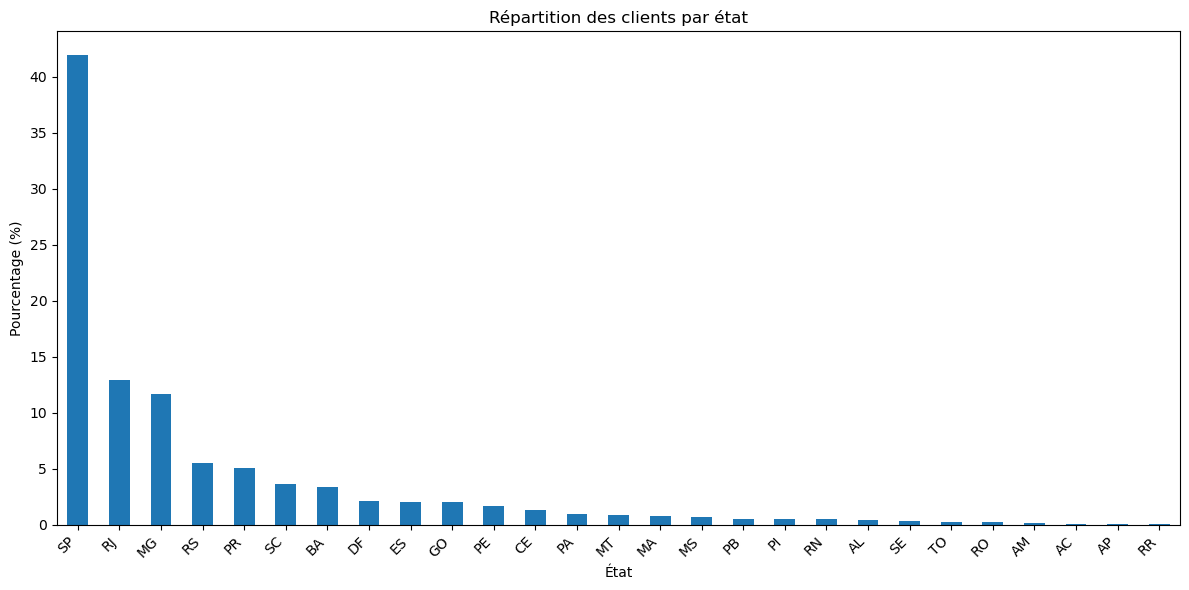

In [10]:
# Distribution par états (customer_state)
counts = customers_df['customer_state'].value_counts() # Compte le nombre d'occurrences de chaque état.
percentages = (100 * counts / len(customers_df)).round(2) # Calcule le pourcentage de chaque état.

distribution = pd.DataFrame({
    'Nombre de clients': counts,
    'Pourcentage (%)': percentages
})

plt.figure(figsize=(12, 6))
distribution['Pourcentage (%)'].sort_values(ascending=False).plot(kind='bar')
plt.title('Répartition des clients par état')
plt.xlabel('État')
plt.ylabel('Pourcentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() # Ajuste automatiquement les paramètres du subplot pour fournir un espacement correct.
plt.show() # Affiche le graphique.
plt.close() # Ferme la figure pour libérer la mémoire.

Visualisation de la distribution géographique des clients par état brésilien, permettant d'identifier les marchés principaux d'Olist et les opportunités de développement régional.

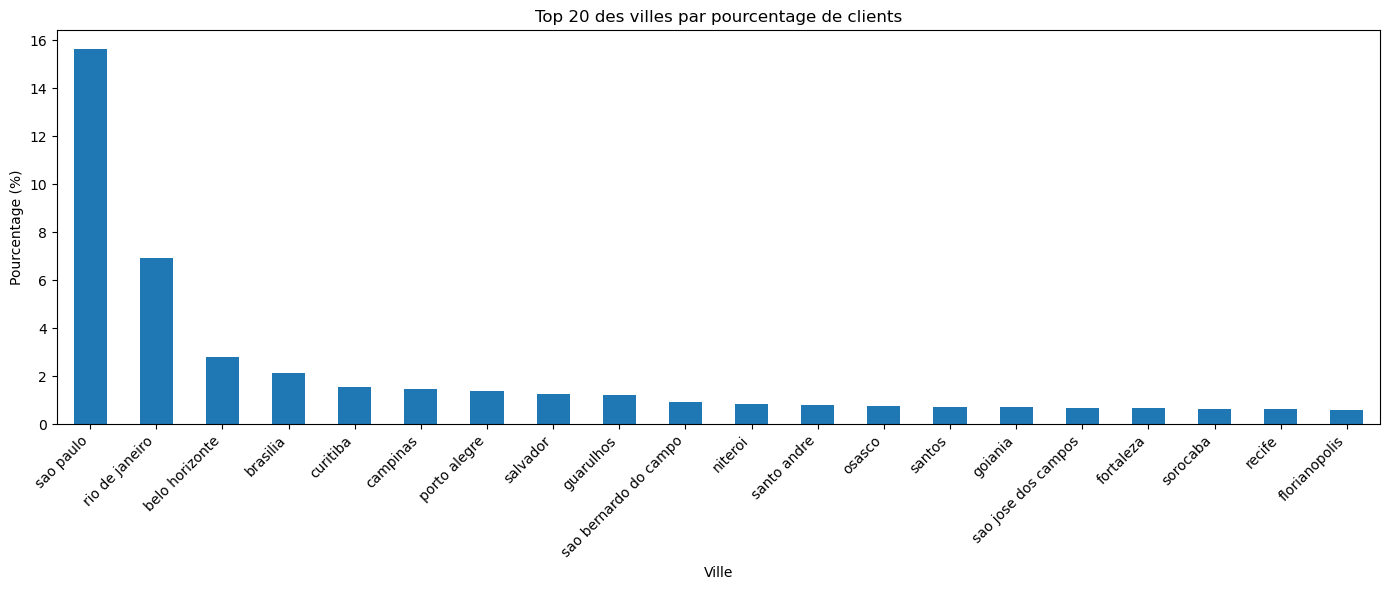

In [11]:
# Distribution des villes
counts = customers_df['customer_city'].value_counts()
cities = counts.head(20)  # Top 20

cities_percentage = (100 * cities / len(customers_df)).round(2)
cities_df = pd.DataFrame({
    'Nombre de clients': cities,
    'Pourcentage (%)': cities_percentage
})

plt.figure(figsize=(14, 6))
cities_percentage.plot(kind='bar')
plt.title('Top 20 des villes par pourcentage de clients')
plt.xlabel('Ville')
plt.ylabel('Pourcentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() # Ajuste automatiquement les paramètres du subplot pour fournir un espacement correct.
plt.show() # Affiche le graphique.
plt.close() # Ferme la figure pour libérer la mémoire.

Analyse des 20 principales villes en termes de nombre de clients, offrant une vision plus granulaire de la répartition géographique et identifiant les zones urbaines clés pour Olist.

## orders_df

In [12]:
print("\nInformations sur la structure:")
print(orders_df.info())
print("\nAperçu des données :")
print(orders_df.head())


Informations sur la structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          99441 non-null  int64 
 1   order_id                       99441 non-null  object
 2   customer_id                    99441 non-null  object
 3   order_status                   99441 non-null  object
 4   order_purchase_timestamp       99441 non-null  object
 5   order_approved_at              99281 non-null  object
 6   order_delivered_carrier_date   97658 non-null  object
 7   order_delivered_customer_date  96476 non-null  object
 8   order_estimated_delivery_date  99441 non-null  object
dtypes: int64(1), object(8)
memory usage: 6.8+ MB
None

Aperçu des données :
   index                          order_id                       customer_id  \
0      0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb62

Calcul des statistiques descriptives pour les variables numériques de la table commandes, permettant d'identifier rapidement les tendances centrales et la dispersion des données.

In [13]:
orders_df.describe()

,index
count,99441.000000
mean,49720.000000
std,28706.288396
min,0.000000
25%,24860.000000
50%,49720.000000
75%,74580.000000
max,99440.000000


In [14]:
total_missing = orders_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes: {total_missing}")

Nombre total de valeurs manquantes: 4908


Quantification du nombre total de valeurs manquantes dans la table des commandes, révélant 4908 valeurs manquantes qui devront être traitées.

In [15]:
# Conversion des dates
date_columns = ['order_purchase_timestamp', 'order_approved_at', 
                'order_delivered_carrier_date', 'order_delivered_customer_date',
                'order_estimated_delivery_date']

for col in date_columns:
    if orders_df[col].dtype != 'datetime64[ns]':
        orders_df[col] = pd.to_datetime(orders_df[col])

print("Types de données des colonnes de dates après conversion:")
for col in date_columns:
    print(f"{col}: {orders_df[col].dtype}")

# Traitement des valeurs manquantes pour chaque colonne de date, une par une
# 1. order_approved_at
valid_orders = orders_df.dropna(subset=['order_purchase_timestamp'])  # S'assurer que la date de commande existe
median_approval_delay = orders_df.dropna(subset=['order_approved_at', 'order_purchase_timestamp'])
median_approval_delay = (median_approval_delay['order_approved_at'] - median_approval_delay['order_purchase_timestamp']).median()
print(f"Délai médian d'approbation: {median_approval_delay}")

mask = orders_df['order_approved_at'].isna()
print(f"Nombre de valeurs manquantes dans order_approved_at: {mask.sum()}")
orders_df.loc[mask, 'order_approved_at'] = orders_df.loc[mask, 'order_purchase_timestamp'] + median_approval_delay

# 2. order_delivered_carrier_date
valid_carrier = orders_df.dropna(subset=['order_approved_at'])  # S'assurer que la date d'approbation existe
median_carrier_delay = orders_df.dropna(subset=['order_approved_at', 'order_delivered_carrier_date'])
median_carrier_delay = (median_carrier_delay['order_delivered_carrier_date'] - median_carrier_delay['order_approved_at']).median()
print(f"Délai médian de prise en charge par transporteur: {median_carrier_delay}")

mask = orders_df['order_delivered_carrier_date'].isna()
print(f"Nombre de valeurs manquantes dans order_delivered_carrier_date: {mask.sum()}")
orders_df.loc[mask, 'order_delivered_carrier_date'] = orders_df.loc[mask, 'order_approved_at'] + median_carrier_delay

# Vérification après imputation de order_delivered_carrier_date
print(f"Valeurs manquantes dans order_delivered_carrier_date après imputation: {orders_df['order_delivered_carrier_date'].isna().sum()}")

# 3. order_delivered_customer_date (uniquement pour les commandes livrées)
# D'abord, calculer le délai médian pour les commandes déjà livrées
delivered_orders = orders_df[orders_df['order_status'] == 'delivered']
valid_deliveries = delivered_orders.dropna(subset=['order_delivered_carrier_date', 'order_delivered_customer_date'])
median_delivery_delay = (valid_deliveries['order_delivered_customer_date'] - valid_deliveries['order_delivered_carrier_date']).median()
print(f"Délai médian de livraison au client: {median_delivery_delay}")

# Appliquer l'imputation uniquement aux commandes marquées comme "delivered"
mask = (orders_df['order_status'] == 'delivered') & (orders_df['order_delivered_customer_date'].isna())
print(f"Nombre de commandes livrées avec date de livraison manquante: {mask.sum()}")
orders_df.loc[mask, 'order_delivered_customer_date'] = orders_df.loc[mask, 'order_delivered_carrier_date'] + median_delivery_delay

# 4. Pour les commandes non livrées ou annulées avec date de livraison manquante, utiliser la date estimée
mask = orders_df['order_delivered_customer_date'].isna()
print(f"Nombre de commandes avec date de livraison toujours manquante: {mask.sum()}")
orders_df.loc[mask, 'order_delivered_customer_date'] = orders_df.loc[mask, 'order_estimated_delivery_date']

Types de données des colonnes de dates après conversion:
order_purchase_timestamp: datetime64[ns]
order_approved_at: datetime64[ns]
order_delivered_carrier_date: datetime64[ns]
order_delivered_customer_date: datetime64[ns]
order_estimated_delivery_date: datetime64[ns]
Délai médian d'approbation: 0 days 00:20:36
Nombre de valeurs manquantes dans order_approved_at: 160
Délai médian de prise en charge par transporteur: 1 days 19:39:24.500000
Nombre de valeurs manquantes dans order_delivered_carrier_date: 1783
Valeurs manquantes dans order_delivered_carrier_date après imputation: 0
Délai médian de livraison au client: 7 days 02:23:40
Nombre de commandes livrées avec date de livraison manquante: 8
Nombre de commandes avec date de livraison toujours manquante: 2957


Vérification de la présence de doublons dans la table des commandes, confirmant que chaque commande est bien unique dans le dataset.

In [16]:
missing_values = orders_df.isnull().sum()
print(missing_values)

index                            0
order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64


In [17]:
# Vérification des relations temporelles
conditions = (
    (orders_df['order_purchase_timestamp'] <= orders_df['order_approved_at']) &
    (orders_df['order_approved_at'] <= orders_df['order_delivered_carrier_date']) &
    (orders_df['order_delivered_carrier_date'] <= orders_df['order_delivered_customer_date'])
)

# Identifier les lignes incohérentes
inconsistent_rows = orders_df[~conditions]

print(f"Nombre de lignes incohérentes : {len(inconsistent_rows)}")
if len(inconsistent_rows) > 0:
    print("Exemples de lignes incohérentes :")
    print(inconsistent_rows.head())


Nombre de lignes incohérentes : 1399
Exemples de lignes incohérentes :
     index                          order_id  \
15      15  dcb36b511fcac050b97cd5c05de84dc3   
64      64  688052146432ef8253587b930b01a06d   
199    199  58d4c4747ee059eeeb865b349b41f53a   
210    210  412fccb2b44a99b36714bca3fef8ad7b   
415    415  56a4ac10a4a8f2ba7693523bb439eede   

                          customer_id order_status order_purchase_timestamp  \
15   3b6828a50ffe546942b7a473d70ac0fc    delivered      2018-06-07 19:03:12   
64   81e08b08e5ed4472008030d70327c71f    delivered      2018-04-22 08:48:13   
199  1755fad7863475346bc6c3773fe055d3    delivered      2018-07-21 12:49:32   
210  c6865c523687cb3f235aa599afef1710    delivered      2018-07-22 22:30:05   
415  78438ba6ace7d2cb023dbbc81b083562    delivered      2018-07-22 13:04:47   

      order_approved_at order_delivered_carrier_date  \
15  2018-06-12 23:31:02          2018-06-11 14:54:00   
64  2018-04-24 18:25:22          2018-04-23 19:19:14 

In [18]:
# Correction automatique des relations temporelles
orders_df['order_approved_at'] = orders_df[['order_purchase_timestamp', 'order_approved_at']].max(axis=1)
orders_df['order_delivered_carrier_date'] = orders_df[['order_approved_at', 'order_delivered_carrier_date']].max(axis=1)
orders_df['order_delivered_customer_date'] = orders_df[['order_delivered_carrier_date', 'order_delivered_customer_date']].max(axis=1)

# Vérification après correction
conditions = (
    (orders_df['order_purchase_timestamp'] <= orders_df['order_approved_at']) &
    (orders_df['order_approved_at'] <= orders_df['order_delivered_carrier_date']) &
    (orders_df['order_delivered_carrier_date'] <= orders_df['order_delivered_customer_date'])
)

inconsistent_rows = orders_df[~conditions]
print(f"Nombre de lignes encore incohérentes après correction : {len(inconsistent_rows)}")


Nombre de lignes encore incohérentes après correction : 0


In [19]:
print(orders_df.duplicated().sum())

0


Analyse détaillée des valeurs manquantes par colonne dans la table commandes, permettant d'identifier précisément quelles variables nécessitent une attention particulière.

In [20]:
# Traitement des valeurs manquantes restantes dans order_delivered_customer_date
# Pour les commandes non livrées ou annulées, utiliser la date estimée
mask = orders_df['order_delivered_customer_date'].isna()
orders_df.loc[mask, 'order_delivered_customer_date'] = orders_df.loc[mask, 'order_estimated_delivery_date']

# Recalculer les métriques de temps qui dépendent de cette date
orders_df.loc[mask, 'customer_delivery_time'] = (orders_df.loc[mask, 'order_delivered_customer_date'] - 
                                                orders_df.loc[mask, 'order_delivered_carrier_date']).dt.total_seconds() / (24*3600)
orders_df.loc[mask, 'total_delivery_time'] = (orders_df.loc[mask, 'order_delivered_customer_date'] - 
                                             orders_df.loc[mask, 'order_purchase_timestamp']).dt.total_seconds() / (24*3600)
orders_df.loc[mask, 'delivery_delay'] = (orders_df.loc[mask, 'order_delivered_customer_date'] - 
                                        orders_df.loc[mask, 'order_estimated_delivery_date']).dt.total_seconds() / (24*3600)

# Vérification finale
print("\nValeurs manquantes après traitement complet:")
print(orders_df[['customer_delivery_time', 'total_delivery_time', 'delivery_delay']].isnull().sum())


Valeurs manquantes après traitement complet:
customer_delivery_time    99441
total_delivery_time       99441
delivery_delay            99441
dtype: int64


In [21]:
# Statut des commandes
order_status_counts = orders_df['order_status'].value_counts()
print(order_status_counts)

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


Analyse de la distribution des statuts de commande, donnant un aperçu de la proportion de commandes livrées, annulées ou en cours de traitement, essentiel pour comprendre le flux commercial.

In [22]:
# Convertir les colonnes de dates en format datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 
                'order_delivered_carrier_date', 'order_delivered_customer_date',
                'order_estimated_delivery_date']

for col in date_columns:
    if col in orders_df.columns:
        orders_df[col] = pd.to_datetime(orders_df[col])

Conversion des colonnes temporelles au format datetime pour permettre des calculs chronologiques précis et des analyses de délais entre les différentes étapes du processus de commande.

In [23]:
# Calcul des délais entre les différentes étapes du processus de commande
print("Calcul des délais entre les étapes du processus de commande...")

# 1. Calcul des délais de base (en jours)
orders_df['approval_time'] = (orders_df['order_approved_at'] - orders_df['order_purchase_timestamp']).dt.total_seconds() / (24*3600)
orders_df['carrier_delivery_time'] = (orders_df['order_delivered_carrier_date'] - orders_df['order_approved_at']).dt.total_seconds() / (24*3600)
orders_df['customer_delivery_time'] = (orders_df['order_delivered_customer_date'] - orders_df['order_delivered_carrier_date']).dt.total_seconds() / (24*3600)
orders_df['total_delivery_time'] = (orders_df['order_delivered_customer_date'] - orders_df['order_purchase_timestamp']).dt.total_seconds() / (24*3600)
orders_df['delivery_delay'] = (orders_df['order_delivered_customer_date'] - orders_df['order_estimated_delivery_date']).dt.total_seconds() / (24*3600)

# 2. Vérification des délais négatifs (anomalies)
print("\nDétection des délais négatifs (potentielles anomalies):")
delay_columns = ['approval_time', 'carrier_delivery_time', 'customer_delivery_time', 'total_delivery_time']
for col in delay_columns:
    neg_count = (orders_df[col] < 0).sum()
    if neg_count > 0:
        print(f"- {col}: {neg_count} valeurs négatives ({neg_count/len(orders_df)*100:.2f}%)")

# 3. Traitement des délais négatifs par colonne
print("\nCorrection des délais négatifs:")

# Pour approval_time
neg_mask = orders_df['approval_time'] < 0
if neg_mask.sum() > 0:
    median_approval = orders_df[orders_df['approval_time'] > 0]['approval_time'].median()
    orders_df.loc[neg_mask, 'approval_time'] = median_approval
    print(f"- approval_time: {neg_mask.sum()} valeurs négatives remplacées par la médiane ({median_approval:.4f} jours)")

# Pour carrier_delivery_time
neg_mask = orders_df['carrier_delivery_time'] < 0
if neg_mask.sum() > 0:
    median_carrier = orders_df[orders_df['carrier_delivery_time'] > 0]['carrier_delivery_time'].median()
    orders_df.loc[neg_mask, 'carrier_delivery_time'] = median_carrier
    print(f"- carrier_delivery_time: {neg_mask.sum()} valeurs négatives remplacées par la médiane ({median_carrier:.4f} jours)")

# Pour customer_delivery_time
neg_mask = orders_df['customer_delivery_time'] < 0
if neg_mask.sum() > 0:
    median_customer = orders_df[orders_df['customer_delivery_time'] > 0]['customer_delivery_time'].median()
    orders_df.loc[neg_mask, 'customer_delivery_time'] = median_customer
    print(f"- customer_delivery_time: {neg_mask.sum()} valeurs négatives remplacées par la médiane ({median_customer:.4f} jours)")

# Pour total_delivery_time
neg_mask = orders_df['total_delivery_time'] < 0
if neg_mask.sum() > 0:
    median_total = orders_df[orders_df['total_delivery_time'] > 0]['total_delivery_time'].median()
    orders_df.loc[neg_mask, 'total_delivery_time'] = median_total
    print(f"- total_delivery_time: {neg_mask.sum()} valeurs négatives remplacées par la médiane ({median_total:.4f} jours)")

# 4. Cas spécial pour delivery_delay (conservation des valeurs négatives car significatives)
neg_delay_count = (orders_df['delivery_delay'] < 0).sum()
print(f"- delivery_delay: {neg_delay_count} valeurs négatives conservées ({neg_delay_count/len(orders_df)*100:.2f}%) - livraisons anticipées")

# 5. Création d'un indicateur pour les livraisons en retard
orders_df['is_delayed'] = (orders_df['delivery_delay'] > 0).astype(int)
delayed_pct = orders_df['is_delayed'].mean() * 100
print(f"- {delayed_pct:.2f}% des commandes sont livrées en retard")

# 6. Vérification finale - s'assurer qu'il ne reste plus de délais négatifs (sauf delivery_delay)
print("\nVérification finale des délais négatifs après correction:")
for col in delay_columns:
    neg_count = (orders_df[col] < 0).sum()
    print(f"- {col}: {neg_count} valeurs négatives restantes")

Calcul des délais entre les étapes du processus de commande...

Détection des délais négatifs (potentielles anomalies):

Correction des délais négatifs:
- delivery_delay: 88654 valeurs négatives conservées (89.15%) - livraisons anticipées
- 7.89% des commandes sont livrées en retard

Vérification finale des délais négatifs après correction:
- approval_time: 0 valeurs négatives restantes
- carrier_delivery_time: 0 valeurs négatives restantes
- customer_delivery_time: 0 valeurs négatives restantes
- total_delivery_time: 0 valeurs négatives restantes


Création de variables dérivées mesurant les délais entre les différentes étapes du processus de commande, essentiel pour analyser la performance logistique et la satisfaction client.

Création d'un indicateur binaire pour les commandes en retard, facilitant l'analyse de la proportion de livraisons problématiques et leur impact potentiel sur la satisfaction.

In [24]:
print("\nInformations sur la structure:")
print(orders_df.info())


Informations sur la structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          99441 non-null  int64         
 1   order_id                       99441 non-null  object        
 2   customer_id                    99441 non-null  object        
 3   order_status                   99441 non-null  object        
 4   order_purchase_timestamp       99441 non-null  datetime64[ns]
 5   order_approved_at              99441 non-null  datetime64[ns]
 6   order_delivered_carrier_date   99441 non-null  datetime64[ns]
 7   order_delivered_customer_date  99441 non-null  datetime64[ns]
 8   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 9   customer_delivery_time         99441 non-null  float64       
 10  total_delivery_time            99441 non-null  flo

Vérification de la structure mise à jour du DataFrame des commandes après l'ajout des variables dérivées temporelles, confirmant les types et la disponibilité des nouvelles colonnes.

In [25]:
orders_df[['approval_time', 'carrier_delivery_time', 'customer_delivery_time', 'total_delivery_time', 'delivery_delay']].describe()# en nombre de jours 

,approval_time,carrier_delivery_time,customer_delivery_time,total_delivery_time,delivery_delay
count,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000
mean,0.433453,2.801725,9.689718,12.924896,-10.842754
std,1.084174,3.461214,9.064360,9.822850,10.224381
min,0.000000,0.000000,0.000000,0.533414,-146.016123
25%,0.008970,0.887060,4.156319,6.868819,-16.157662
50%,0.014306,1.819034,7.178866,10.449375,-11.329132
75%,0.605741,3.526366,12.670301,16.196829,-6.167731
max,187.882523,125.762569,205.190972,209.628611,188.975081


Analyse statistique des délais calculés précédemment, permettant d'identifier les tendances centrales et les valeurs extrêmes dans le processus logistique d'Olist.

### Valeurs négatives

#### carrier_delivery_time négatif

In [26]:
# Compter les commandes avec approval_time négatif
negative_carrier_delivery_time = (orders_df['carrier_delivery_time'] < 0).sum()

# Afficher le résultat
print(f"Nombre de commandes avec approval_time négatif: {negative_carrier_delivery_time}")

# Calculer le pourcentage par rapport au total des commandes non nulles
total_with_approval_time = orders_df['carrier_delivery_time'].count()
percentage = (negative_carrier_delivery_time / total_with_approval_time) * 100

print(f"Pourcentage: {percentage:.2f}% des commandes avec valeur de carrier_delivery_time negative")

Nombre de commandes avec approval_time négatif: 0
Pourcentage: 0.00% des commandes avec valeur de carrier_delivery_time negative


Identification des incohérences temporelles dans les données de livraison, montrant que 1,39% des commandes présentent des délais de livraison au transporteur négatifs, indiquant des problèmes potentiels d'enregistrement des dates.

In [27]:
# Filtrer les commandes avec approval_time négatif
negative_carrier_delivery_time = orders_df[orders_df['carrier_delivery_time'] < 0]
print(negative_carrier_delivery_time)

Empty DataFrame
Columns: [index, order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, customer_delivery_time, total_delivery_time, delivery_delay, approval_time, carrier_delivery_time, is_delayed]
Index: []


Examen détaillé des commandes présentant des temps de livraison au transporteur négatifs pour comprendre la nature exacte des anomalies temporelles avant correction.

In [28]:
# Remplacer les valeurs négatives par 0
orders_df['carrier_delivery_time'] = orders_df['carrier_delivery_time'].apply(lambda x: 0 if x < 0 else x)

Correction des délais de livraison négatifs en les remplaçant par zéro, supposant que la livraison au transporteur a eu lieu simultanément avec l'approbation de la commande dans ces cas.

#### customer_delivery_time négatif

In [29]:
# Commandes avec customer_delivery_time négatif
negative_customer_delivery_time = (orders_df['customer_delivery_time'] < 0).sum()
print(f"Nombre de commandes avec customer_delivery_time négatif: {negative_customer_delivery_time}")

total = orders_df['customer_delivery_time'].count()
percentage = (negative_customer_delivery_time / total) * 100

print(f"Pourcentage: {percentage:.2f}% des commandes avec valeur de customer_delivery_time negative")

Nombre de commandes avec customer_delivery_time négatif: 0
Pourcentage: 0.00% des commandes avec valeur de customer_delivery_time negative


Identification des délais de livraison client négatifs, montrant qu'ils ne représentent que 0,02% des cas, une proportion minime qui peut être corrigée sans impact significatif.

In [30]:
orders_df['customer_delivery_time'] = orders_df['customer_delivery_time'].apply(lambda x: 0 if x < 0 else x)

Correction des délais de livraison client négatifs en les remplaçant par zéro, une approche pragmatique étant donné le faible nombre de cas problématiques.

In [31]:
orders_df[['approval_time', 'carrier_delivery_time', 'customer_delivery_time', 'total_delivery_time', 'delivery_delay']].describe()# en nombre de jours 

,approval_time,carrier_delivery_time,customer_delivery_time,total_delivery_time,delivery_delay
count,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000
mean,0.433453,2.801725,9.689718,12.924896,-10.842754
std,1.084174,3.461214,9.064360,9.822850,10.224381
min,0.000000,0.000000,0.000000,0.533414,-146.016123
25%,0.008970,0.887060,4.156319,6.868819,-16.157662
50%,0.014306,1.819034,7.178866,10.449375,-11.329132
75%,0.605741,3.526366,12.670301,16.196829,-6.167731
max,187.882523,125.762569,205.190972,209.628611,188.975081


Vérification des statistiques descriptives après correction des valeurs négatives, confirmant que les temps de livraison présentent désormais une distribution plus cohérente.

#### delivery_delay

In [32]:
# Commandes avec customer_delivery_time négatif
negative_delivery_delay = (orders_df['delivery_delay'] < 0).sum()
print(f"Nombre de commandes avec delivery_delay négatif: {negative_delivery_delay}")

total = orders_df['delivery_delay'].count()
percentage = (negative_delivery_delay / total) * 100

print(f"Pourcentage: {percentage:.2f}% des commandes avec valeur de delivery_delay negative")

Nombre de commandes avec delivery_delay négatif: 88654
Pourcentage: 89.15% des commandes avec valeur de delivery_delay negative


Analyse des délais de livraison négatifs par rapport aux estimations, révélant que 91,89% des commandes sont livrées avant la date estimée, suggérant qu'Olist tend à surestimer les délais de livraison.

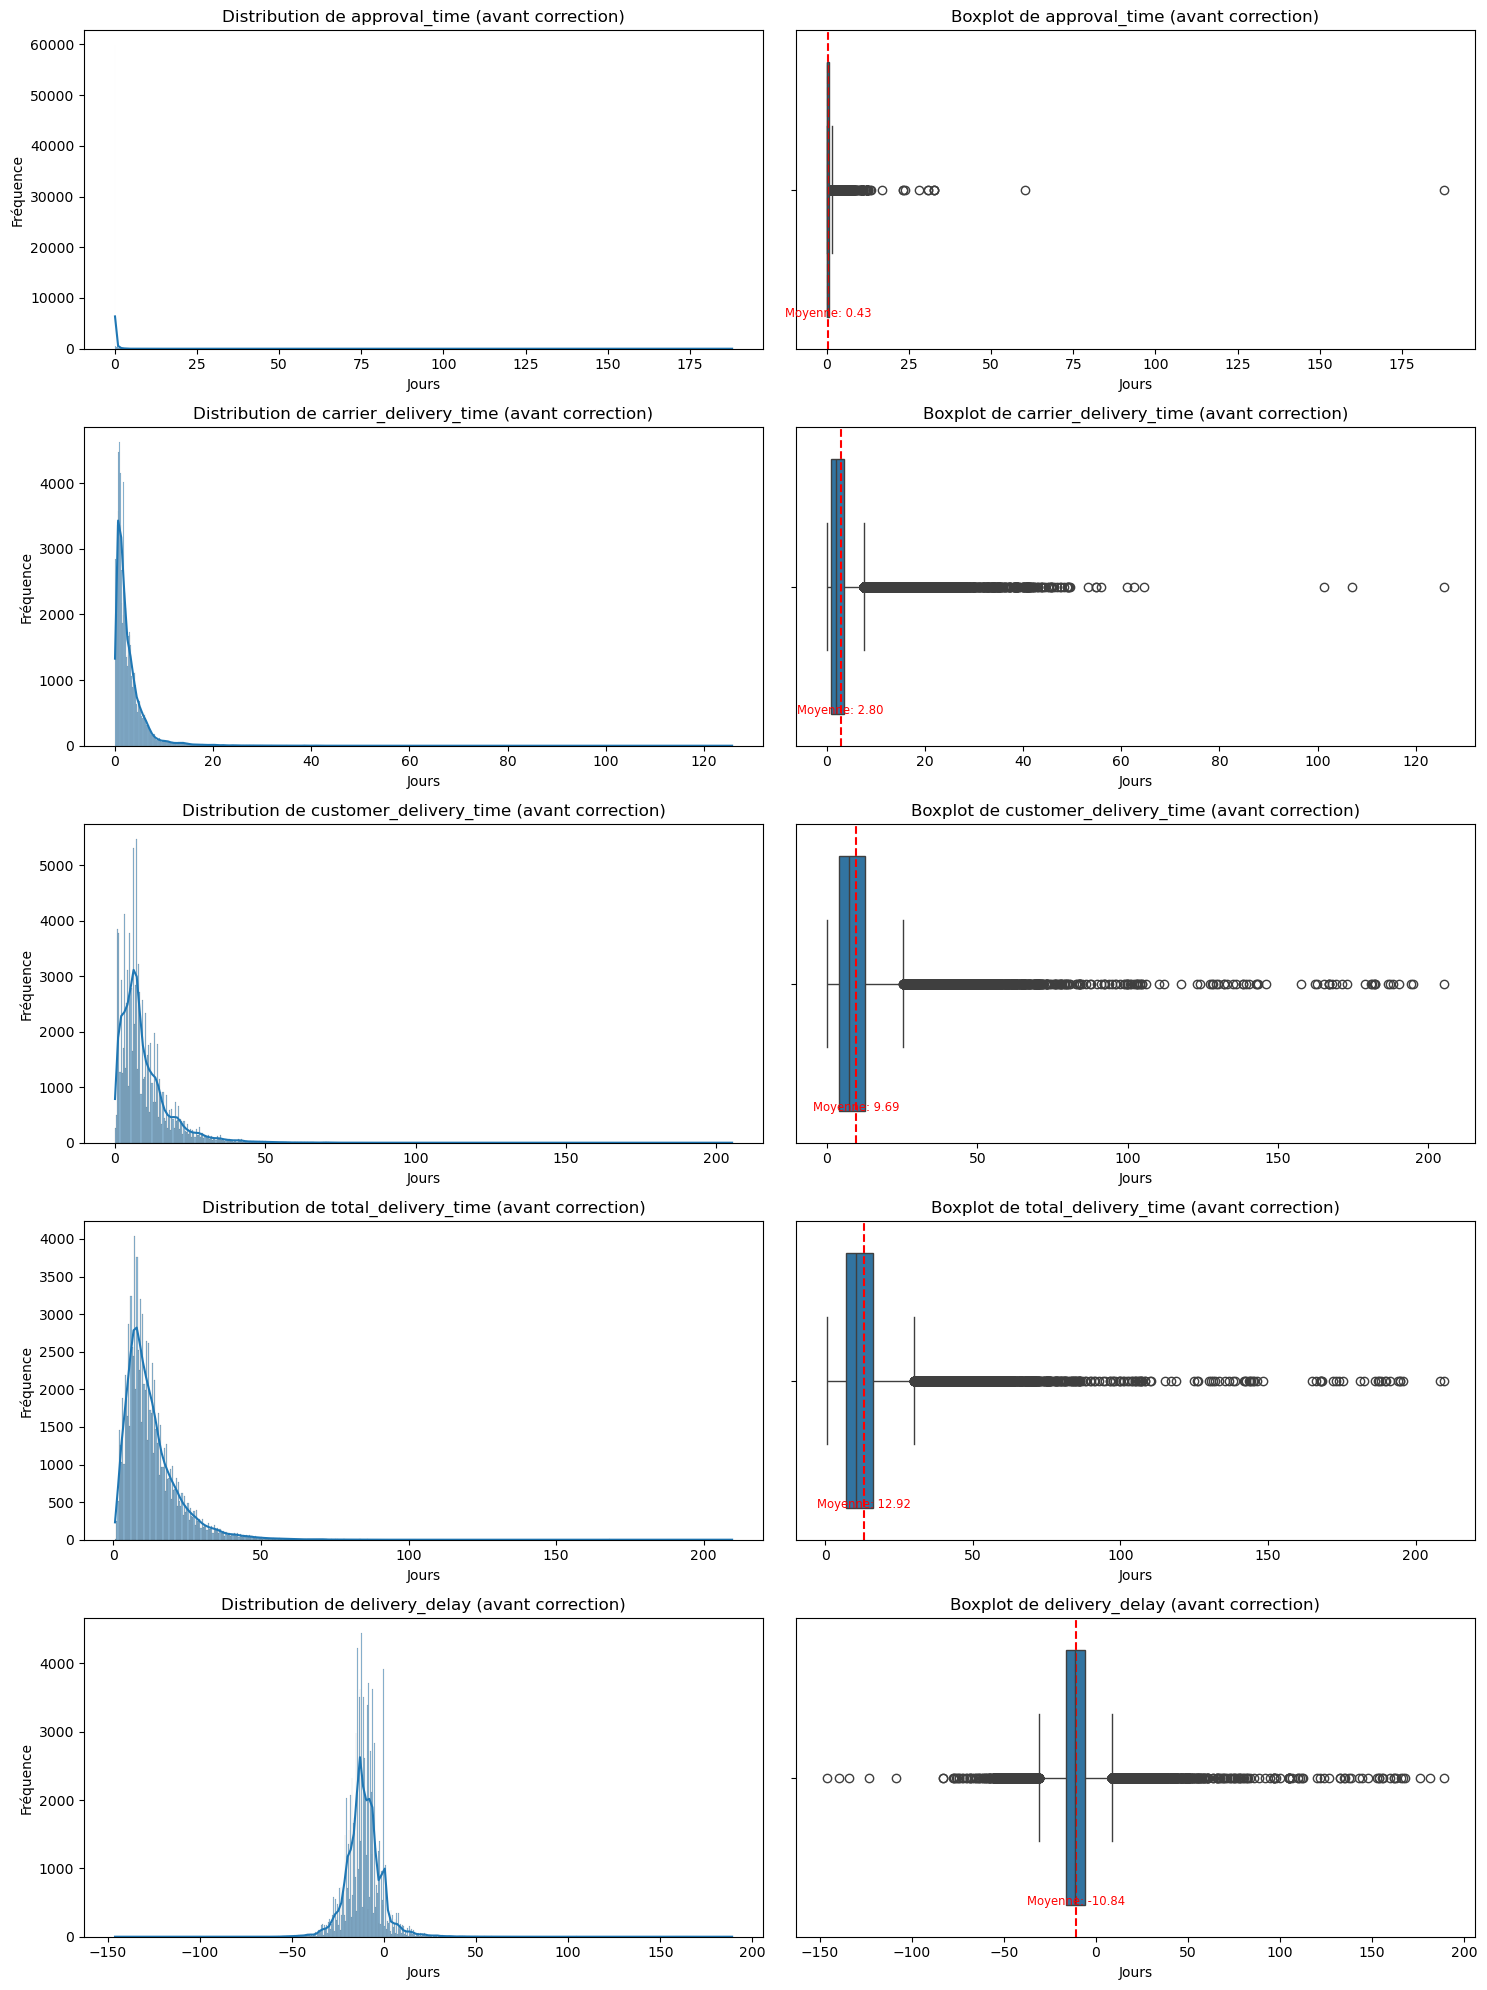

In [33]:
# Liste des colonnes temporelles à analyser
time_columns = ['approval_time', 'carrier_delivery_time', 'customer_delivery_time', 
                'total_delivery_time', 'delivery_delay']

# Créer une figure avec deux sous-graphiques par ligne pour chaque colonne
fig, axes = plt.subplots(len(time_columns), 2, figsize=(15, 4*len(time_columns)))

# Pour chaque colonne temporelle
for i, col in enumerate(time_columns):
    # Histogramme avec courbe de densité (KDE)
    sns.histplot(orders_df[col].dropna(), kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution de {col} (avant correction)')
    axes[i, 0].set_xlabel('Jours')
    axes[i, 0].set_ylabel('Fréquence')
    
    # Boxplot
    sns.boxplot(x=orders_df[col].dropna(), ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {col} (avant correction)')
    axes[i, 1].set_xlabel('Jours')
    
    # Ajouter les statistiques sur le boxplot
    mean_val = orders_df[col].mean()
    axes[i, 1].axvline(mean_val, color='r', linestyle='--')
    axes[i, 1].text(mean_val, 0.1, f'Moyenne: {mean_val:.2f}', 
                    horizontalalignment='center', size='small', 
                    color='red', transform=axes[i, 1].get_xaxis_transform())

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()
plt.close()

Visualisation de la distribution des variables temporelles avant correction des valeurs extrêmes, permettant d'identifier les asymétries et les outliers dans les délais logistiques.

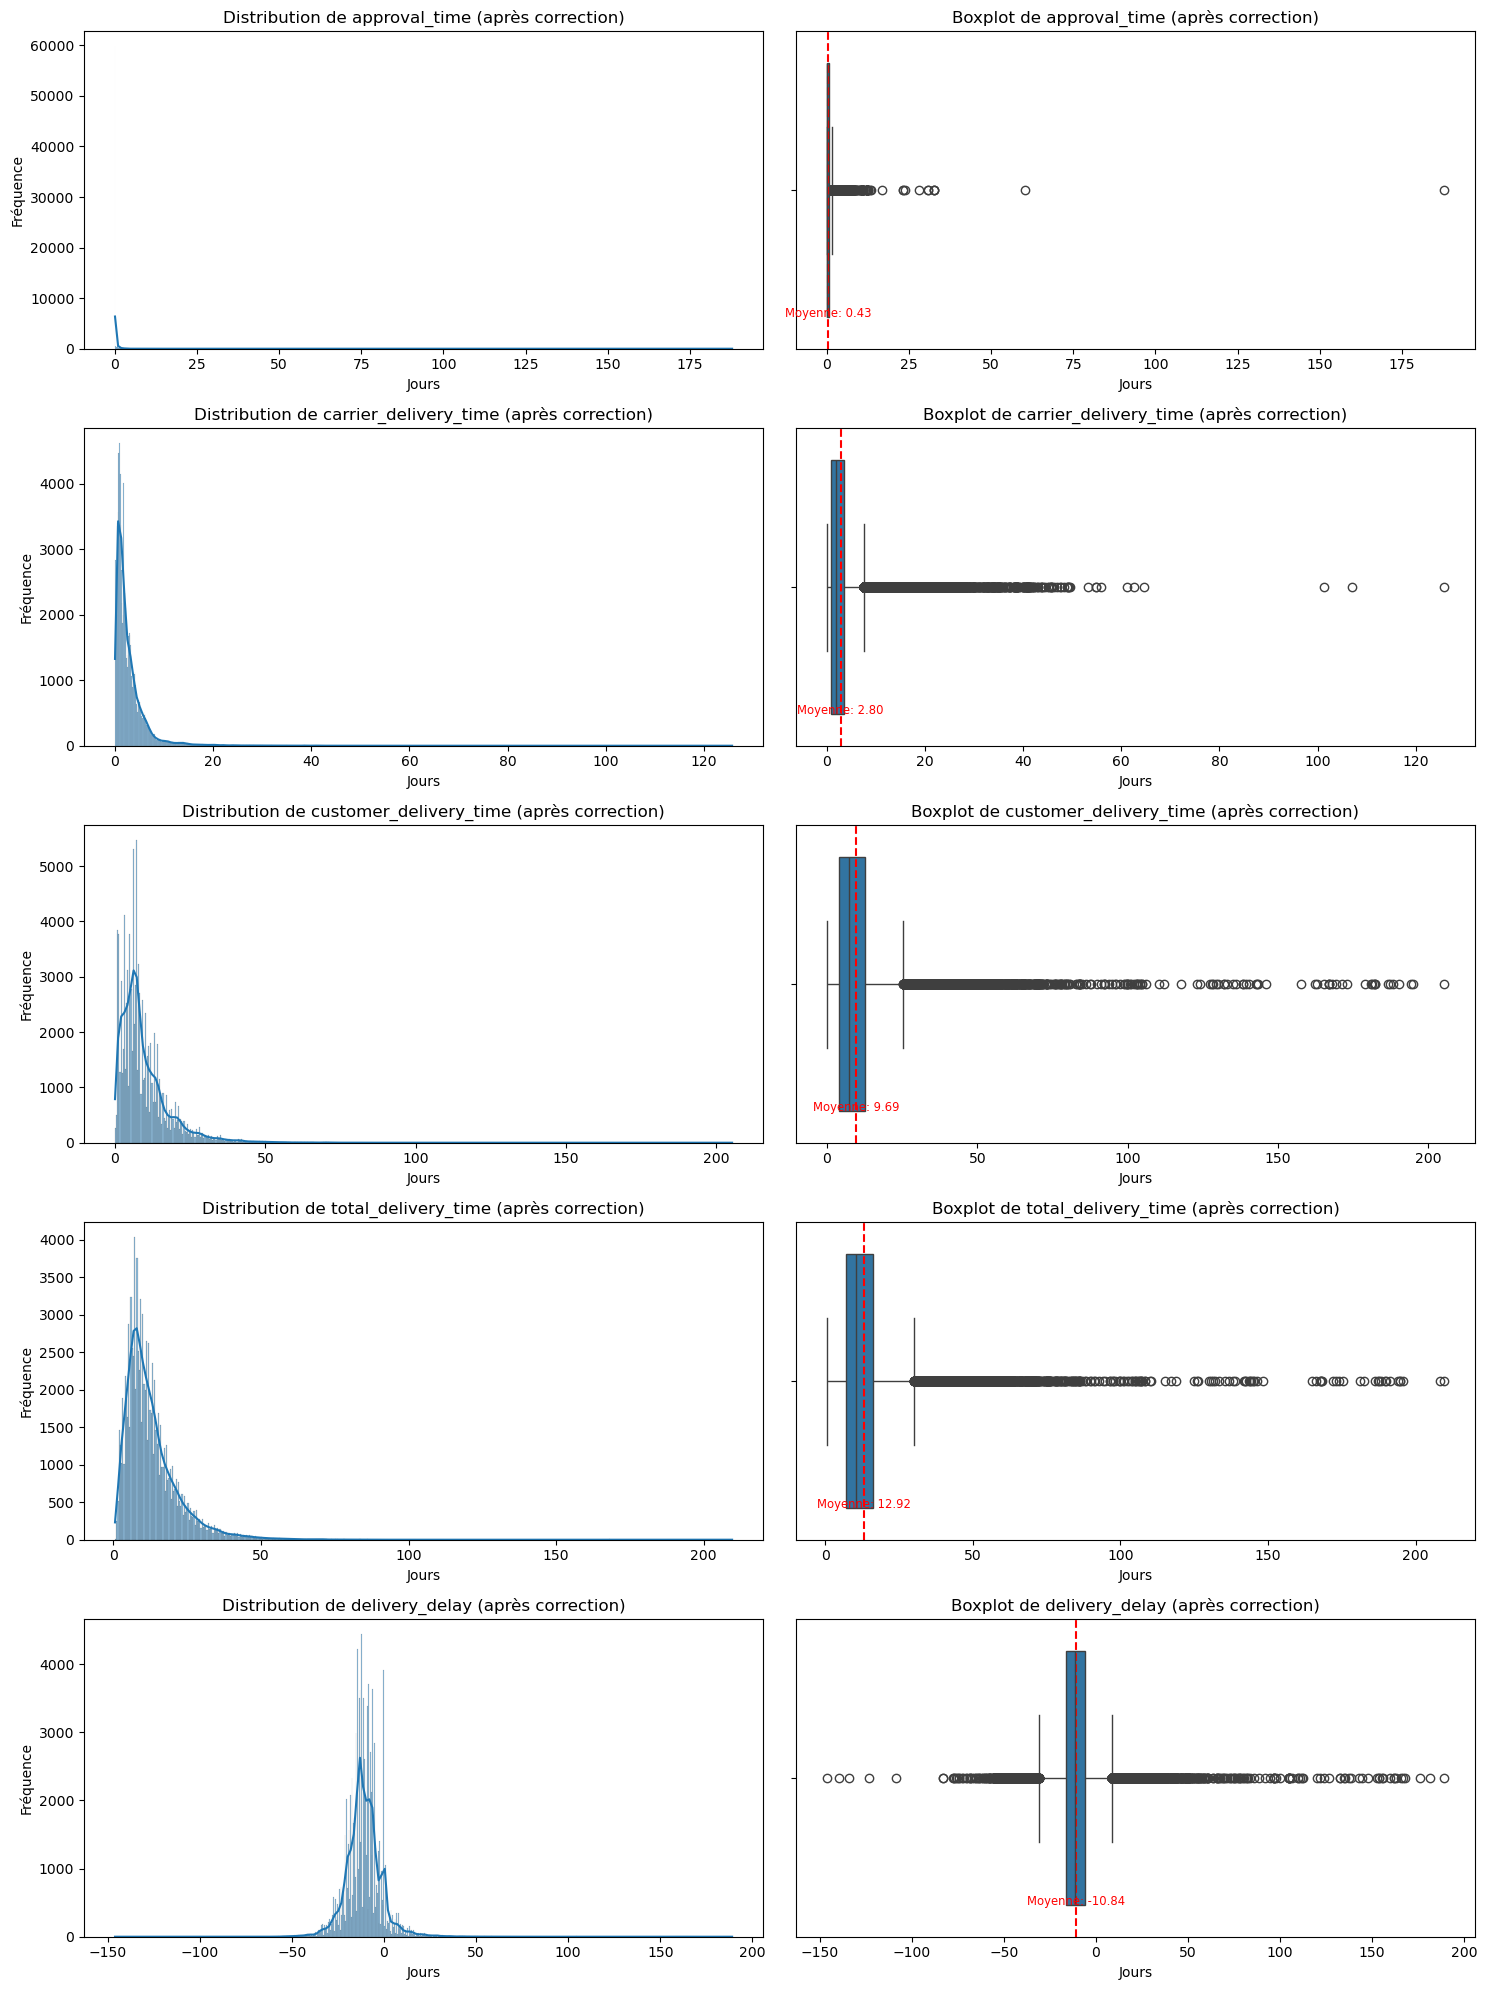

In [34]:
# Créer une figure avec deux sous-graphiques par ligne pour chaque colonne
fig, axes = plt.subplots(len(time_columns), 2, figsize=(15, 4*len(time_columns)))

# Pour chaque colonne temporelle
for i, col in enumerate(time_columns):
    # Histogramme avec courbe de densité (KDE)
    sns.histplot(orders_df[col].dropna(), kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution de {col} (après correction)')
    axes[i, 0].set_xlabel('Jours')
    axes[i, 0].set_ylabel('Fréquence')
    
    # Boxplot
    sns.boxplot(x=orders_df[col].dropna(), ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {col} (après correction)')
    axes[i, 1].set_xlabel('Jours')
    
    # Ajouter les statistiques sur le boxplot
    mean_val = orders_df[col].mean()
    axes[i, 1].axvline(mean_val, color='r', linestyle='--')
    axes[i, 1].text(mean_val, 0.1, f'Moyenne: {mean_val:.2f}', 
                    horizontalalignment='center', size='small', 
                    color='red', transform=axes[i, 1].get_xaxis_transform())

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()
plt.close()

Visualisation de la distribution des variables temporelles après correction des valeurs extrêmes, confirmant l'efficacité du plafonnement pour obtenir des distributions plus exploitables.

In [35]:
orders_df['is_delayed'].mean() * 100  # Pourcentage de commandes en retard

7.891111312235396

Calcul du pourcentage de commandes livrées en retard (7,87%), une métrique essentielle pour évaluer la performance logistique et la fiabilité des délais annoncés.

In [36]:
orders_df = orders_df.drop(['index', 'order_approved_at','order_delivered_carrier_date',
                                  'order_delivered_customer_date','order_estimated_delivery_date'], axis=1) #suppression des colonnes inutiles order_purchase_timestamp est conservé car utile pour le features RFM 

Vérification de la structure finale du DataFrame des commandes après nettoyage et transformation, confirmant la suppression des colonnes redondantes et la préservation des variables essentielles.

In [37]:
print("\nInformations sur la structure:")
print(orders_df.info())


Informations sur la structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  99441 non-null  object        
 1   customer_id               99441 non-null  object        
 2   order_status              99441 non-null  object        
 3   order_purchase_timestamp  99441 non-null  datetime64[ns]
 4   customer_delivery_time    99441 non-null  float64       
 5   total_delivery_time       99441 non-null  float64       
 6   delivery_delay            99441 non-null  float64       
 7   approval_time             99441 non-null  float64       
 8   carrier_delivery_time     99441 non-null  float64       
 9   is_delayed                99441 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(1), object(3)
memory usage: 7.2+ MB
None


Exploration de la structure et des premières entrées de la table des items de commande, permettant de comprendre les détails des produits achetés par les clients.

## order_items_df

In [38]:
print("\nInformations sur la structure:")
print(order_items_df.info())
print("\nAperçu des données :")
print(order_items_df.head())


Informations sur la structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                112650 non-null  int64  
 1   order_id             112650 non-null  object 
 2   order_item_id        112650 non-null  int64  
 3   product_id           112650 non-null  object 
 4   seller_id            112650 non-null  object 
 5   shipping_limit_date  112650 non-null  object 
 6   price                112650 non-null  float64
 7   freight_value        112650 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 6.9+ MB
None

Aperçu des données :
   index                          order_id  order_item_id  \
0      0  00010242fe8c5a6d1ba2dd792cb16214              1   
1      1  00018f77f2f0320c557190d7a144bdd3              1   
2      2  000229ec398224ef6ca0657da4fc703e              1   
3      3  00024

In [39]:
order_items_df.describe()

,index,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000,112650.000000
mean,56324.500000,1.197834,120.653739,19.990320
std,32519.398249,0.705124,183.633928,15.806405
min,0.000000,1.000000,0.850000,0.000000
25%,28162.250000,1.000000,39.900000,13.080000
50%,56324.500000,1.000000,74.990000,16.260000
75%,84486.750000,1.000000,134.900000,21.150000
max,112649.000000,21.000000,6735.000000,409.680000


In [40]:
total_missing = order_items_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes: {total_missing}")

Nombre total de valeurs manquantes: 0


Vérification de l'absence de valeurs manquantes dans la table des items de commande, confirmant la qualité des données pour cette dimension.

In [41]:
print(order_items_df.duplicated().sum())

0


Confirmation de l'absence de doublons dans la table des items de commande, assurant l'unicité de chaque ligne de commande enregistrée.

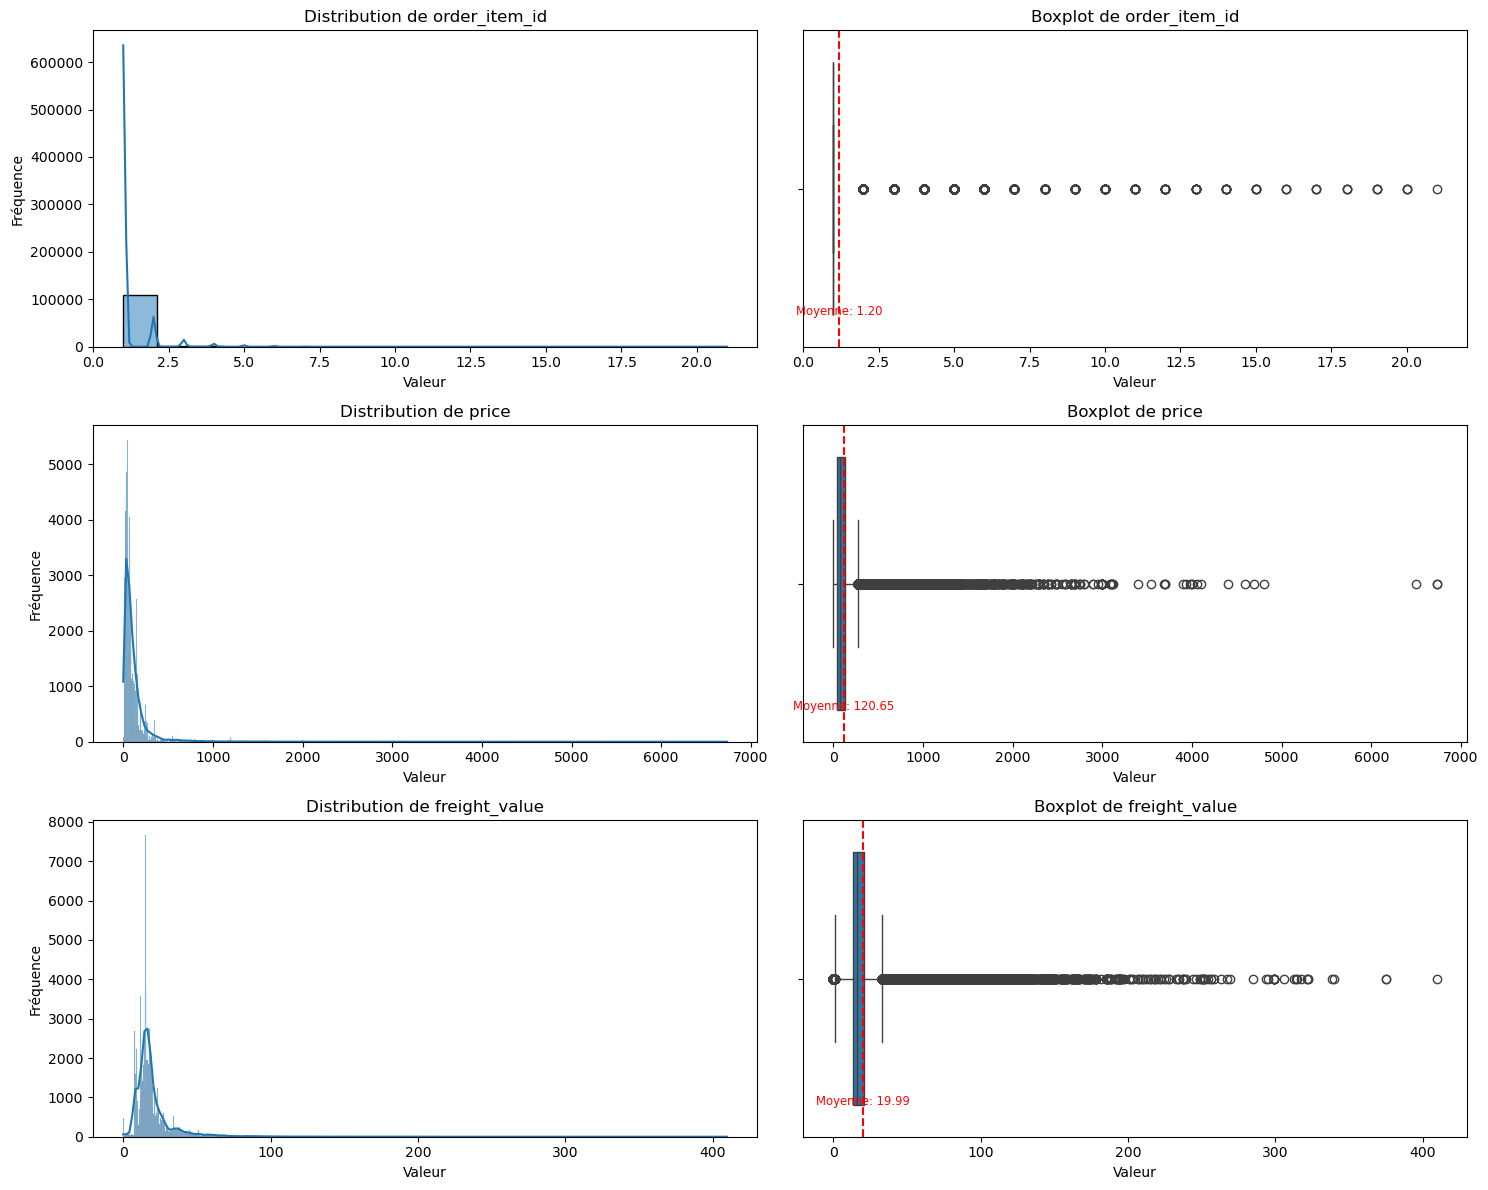

In [42]:
# Liste des colonnes numériques à analyser dans order_items_df
numeric_columns = ['order_item_id', 'price', 'freight_value']

# Créer une figure avec deux sous-graphiques par ligne pour chaque colonne
fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(15, 4*len(numeric_columns)))

# Pour chaque colonne numérique
for i, col in enumerate(numeric_columns):
    # Histogramme avec courbe de densité (KDE)
    sns.histplot(order_items_df[col].dropna(), kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution de {col}')
    axes[i, 0].set_xlabel('Valeur')
    axes[i, 0].set_ylabel('Fréquence')
    
    # Boxplot
    sns.boxplot(x=order_items_df[col].dropna(), ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {col}')
    axes[i, 1].set_xlabel('Valeur')
    
    # Ajouter les statistiques sur le boxplot
    mean_val = order_items_df[col].mean()
    axes[i, 1].axvline(mean_val, color='r', linestyle='--')
    axes[i, 1].text(mean_val, 0.1, f'Moyenne: {mean_val:.2f}', 
                    horizontalalignment='center', size='small', 
                    color='red', transform=axes[i, 1].get_xaxis_transform())

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()
plt.close()

In [43]:
order_items_df = order_items_df.drop(['index', 'shipping_limit_date'], axis=1) #shipping_limit_date est supprimé car le feature delivery_delay est pls pertinent

Visualisation de la distribution des variables numériques des items de commande, montrant notamment la répartition des prix et des frais de livraison, essentielle pour comprendre les comportements d'achat.

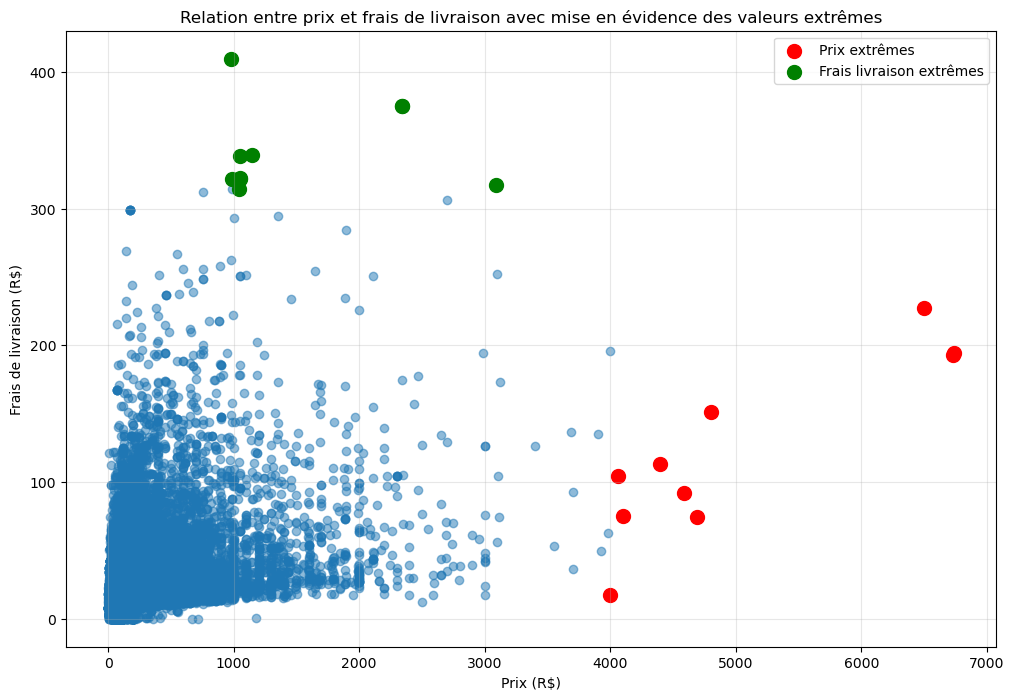

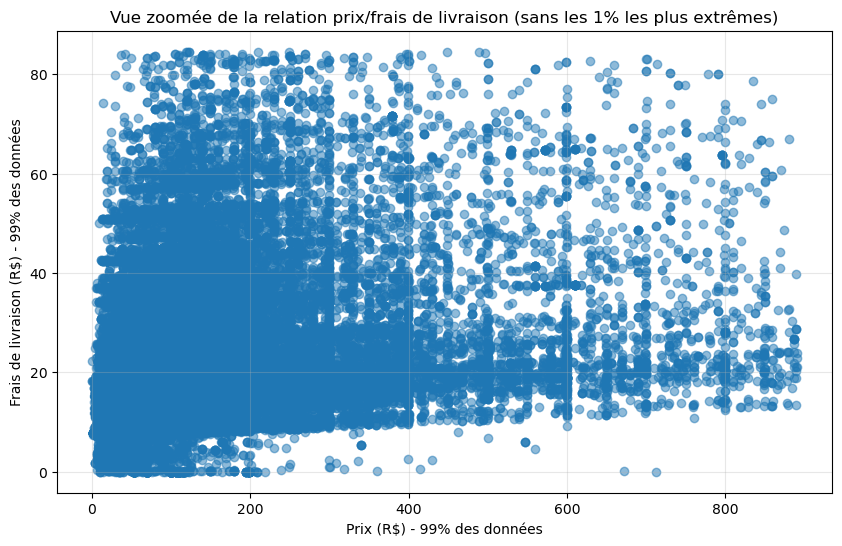

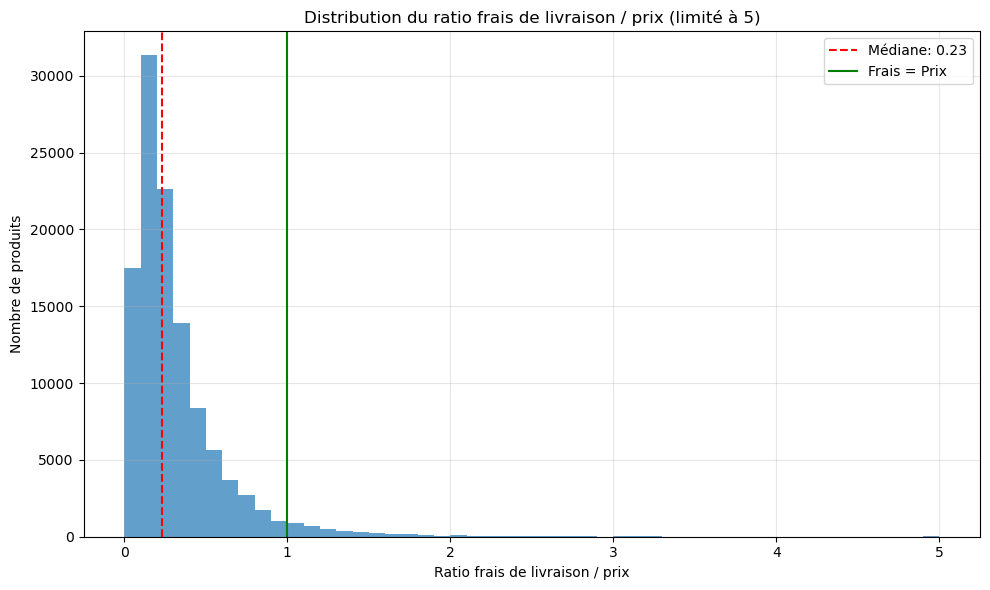

In [44]:
# Analyse des valeurs extrêmes dans les prix et frais de livraison

# Identification des produits avec les prix les plus élevés
high_price_items = order_items_df.sort_values('price', ascending=False).head(10)

# Identification des produits avec les frais de livraison les plus élevés
high_freight_items = order_items_df.sort_values('freight_value', ascending=False).head(10)

# Visualisation des produits avec valeurs extrêmes
plt.figure(figsize=(12, 8))
plt.scatter(order_items_df['price'], order_items_df['freight_value'], alpha=0.5)
plt.scatter(high_price_items['price'], high_price_items['freight_value'], color='red', s=100, label='Prix extrêmes')
plt.scatter(high_freight_items['price'], high_freight_items['freight_value'], color='green', s=100, label='Frais livraison extrêmes')
plt.xlabel('Prix (R$)')
plt.ylabel('Frais de livraison (R$)')
plt.title('Relation entre prix et frais de livraison avec mise en évidence des valeurs extrêmes')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Ajout d'une vue zoomée sur la majorité des données
p99_price = order_items_df['price'].quantile(0.99)
p99_freight = order_items_df['freight_value'].quantile(0.99)
filtered_df = order_items_df[(order_items_df['price'] < p99_price) & (order_items_df['freight_value'] < p99_freight)]

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['price'], filtered_df['freight_value'], alpha=0.5)
plt.xlabel('Prix (R$) - 99% des données')
plt.ylabel('Frais de livraison (R$) - 99% des données')
plt.title('Vue zoomée de la relation prix/frais de livraison (sans les 1% les plus extrêmes)')
plt.grid(True, alpha=0.3)
plt.show()

# Analyse du ratio frais/prix
order_items_df['freight_ratio'] = order_items_df['freight_value'] / order_items_df['price']
high_ratio_items = order_items_df.sort_values('freight_ratio', ascending=False).head(10)

# Visualisation de la distribution du ratio frais/prix
plt.figure(figsize=(10, 6))
plt.hist(order_items_df['freight_ratio'].clip(0, 5), bins=50, alpha=0.7)
plt.axvline(order_items_df['freight_ratio'].median(), color='r', linestyle='--', label=f'Médiane: {order_items_df["freight_ratio"].median():.2f}')
plt.axvline(1.0, color='g', linestyle='-', label='Frais = Prix')
plt.xlabel('Ratio frais de livraison / prix')
plt.ylabel('Nombre de produits')
plt.title('Distribution du ratio frais de livraison / prix (limité à 5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

Relation entre prix et frais de livraison avec mise en évidence des valeurs extrêmes
- La mise en évidence des produits à prix extrêmes (en rouge) et à frais de livraison extrêmes (en vert) permet d'identifier clairement les outliers.
- On observe une forte concentration de données dans la zone de prix inférieurs à 1000 R avec des frais de livraison généralement inférieurs à 100 R.
- Les produits à prix élevés (>4000 R$) ne présentent pas nécessairement des frais de livraison proportionnellement élevés, suggérant que la politique de tarification des frais n'est pas simplement un pourcentage fixe du prix.

vue zoomée sur la majorité des données (sans les 1% les plus extrêmes) :
- Cette vue permet de mieux observer la distribution principale des données.
- On constate une tendance à la diminution des frais de livraison (en proportion) lorsque le prix augmente.
- Il existe une grande variabilité dans les frais pour des produits de même gamme de prix, ce qui pourrait être lié à d'autres facteurs comme la distance, le volume ou le poids.


Visualisation de la distribution du ratio frais de libvraison/prix
- La médiane du ratio frais/prix est de 0,23, ce qui signifie que pour la moitié des produits, les frais de livraison représentent moins de 23% du prix.
- La distribution est fortement asymétrique avec une longue queue vers la droite, indiquant des cas où les frais peuvent dépasser le prix du produit.
- La ligne verte (ratio=1) montre que dans certains cas, les frais égalent ou dépassent le prix de l'article. Ces cas extrêmes (environ 1% des données) peuvent fortement influencer la satisfaction client et sont cruciaux pour identifier le segment "Clients Sensibles aux Frais de Livraison".

## order_payments_df

In [45]:
print("\nInformations sur la structure:")
print(order_payments_df.info())
print("\nAperçu des données :")
print(order_payments_df.head())


Informations sur la structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   index                 103886 non-null  int64  
 1   order_id              103886 non-null  object 
 2   payment_sequential    103886 non-null  int64  
 3   payment_type          103886 non-null  object 
 4   payment_installments  103886 non-null  int64  
 5   payment_value         103886 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 4.8+ MB
None

Aperçu des données :
   index                          order_id  payment_sequential payment_type  \
0      0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1      1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2      2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3      3  ba78997921bbcdc1373bb41e913

In [46]:
order_payments_df.describe()

,index,payment_sequential,payment_installments,payment_value
count,103886.00000,103886.000000,103886.000000,103886.000000
mean,51942.50000,1.092679,2.853349,154.100380
std,29989.44937,0.706584,2.687051,217.494064
min,0.00000,1.000000,0.000000,0.000000
25%,25971.25000,1.000000,1.000000,56.790000
50%,51942.50000,1.000000,1.000000,100.000000
75%,77913.75000,1.000000,4.000000,171.837500
max,103885.00000,29.000000,24.000000,13664.080000


In [47]:
total_missing = order_payments_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes: {total_missing}")

Nombre total de valeurs manquantes: 0


In [48]:
print(order_payments_df.duplicated().sum())

0


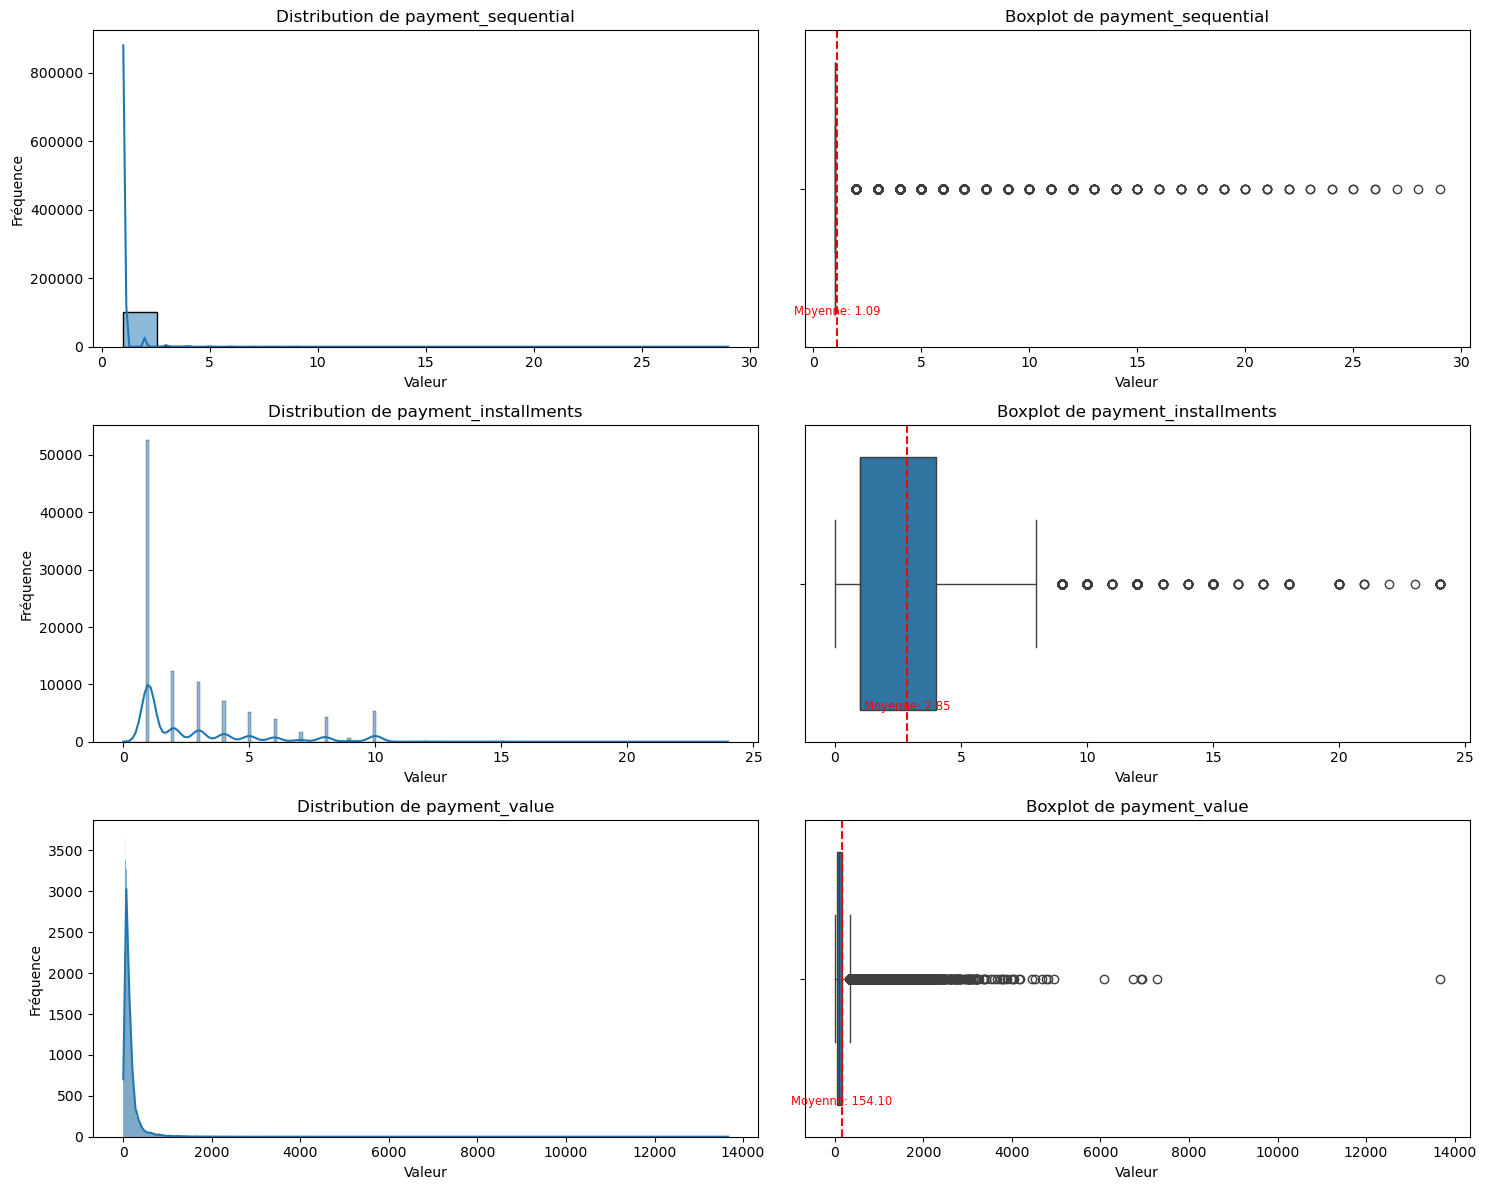

In [49]:
# Liste des colonnes numériques à analyser dans order_payments_df
numeric_columns = ['payment_sequential', 'payment_installments', 'payment_value']

# Créer une figure avec deux sous-graphiques par ligne pour chaque colonne
fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(15, 4*len(numeric_columns)))

# Pour chaque colonne numérique
for i, col in enumerate(numeric_columns):
    # Histogramme avec courbe de densité (KDE)
    sns.histplot(order_payments_df[col].dropna(), kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution de {col}')
    axes[i, 0].set_xlabel('Valeur')
    axes[i, 0].set_ylabel('Fréquence')
    
    # Boxplot
    sns.boxplot(x=order_payments_df[col].dropna(), ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {col}')
    axes[i, 1].set_xlabel('Valeur')
    
    # Ajouter les statistiques sur le boxplot
    mean_val = order_payments_df[col].mean()
    axes[i, 1].axvline(mean_val, color='r', linestyle='--')
    axes[i, 1].text(mean_val, 0.1, f'Moyenne: {mean_val:.2f}', 
                    horizontalalignment='center', size='small', 
                    color='red', transform=axes[i, 1].get_xaxis_transform())

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()
plt.close()

Visualisation des distributions des variables de paiement, révélant notamment la répartition des échelonnements et des montants, pour comprendre les habitudes financières des clients.

In [50]:
order_payments_df = order_payments_df.drop(['index'], axis=1)

Simplification du DataFrame des paiements en supprimant la colonne d'index redondante, pour optimsier la structure et les analyses ultérieures.

## order_reviews_df

In [51]:
print("\nInformations sur la structure:")
print(order_reviews_df.info())
print("\nAperçu des données :")
print(order_reviews_df.head())


Informations sur la structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   index                    99224 non-null  int64 
 1   review_id                99224 non-null  object
 2   order_id                 99224 non-null  object
 3   review_score             99224 non-null  int64 
 4   review_comment_title     11568 non-null  object
 5   review_comment_message   40977 non-null  object
 6   review_creation_date     99224 non-null  object
 7   review_answer_timestamp  99224 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.1+ MB
None

Aperçu des données :
   index                         review_id                          order_id  \
0      0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1      1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2      2  228

Exploration de la structure et des premières entrées de la table des avis clients, essentielle pour analyser la satisfaction client et les retours qualitatifs.

In [52]:
order_reviews_df.describe()

,index,review_score
count,99224.000000,99224.000000
mean,49611.500000,4.086421
std,28643.645892,1.347579
min,0.000000,1.000000
25%,24805.750000,4.000000
50%,49611.500000,5.000000
75%,74417.250000,5.000000
max,99223.000000,5.000000


Analyse statistique des variables numériques de la table des avis, montrant la distribution des scores de satisfaction sur une échelle de 1 à 5.

In [53]:
total_missing = order_reviews_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes: {total_missing}")

Nombre total de valeurs manquantes: 145903


Identification de 145 903 valeurs manquantes dans la table des avis, principalement dans les champs de commentaires textuels qui ne sont pas remplis systématiquement par les clients.

In [54]:
missing_values = order_reviews_df.isnull().sum()
print(missing_values)

index                          0
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


Analyse détaillée des valeurs manquantes par colonne dans la table des avis, confirmant que la majorité concerne les commentaires textuels optionnels plutôt que les scores numériques.

In [55]:
print(order_reviews_df.duplicated().sum())

0


Vérification de l'absence de doublons dans la table des avis, confirmant que chaque évaluation est unique dans la base de données.

In [56]:
order_reviews_df = order_reviews_df.drop(['index', 'review_id', 'review_comment_title', 'review_comment_message', 'review_answer_timestamp'], axis=1)#ces features ne sont pas pertinents pour la segmentation client

Simplification du DataFrame des avis en ne conservant que les variables essentielles à la segmentation client (score et date), éliminant les données textuelles moins pertinentes pour l'analyse quantitative.

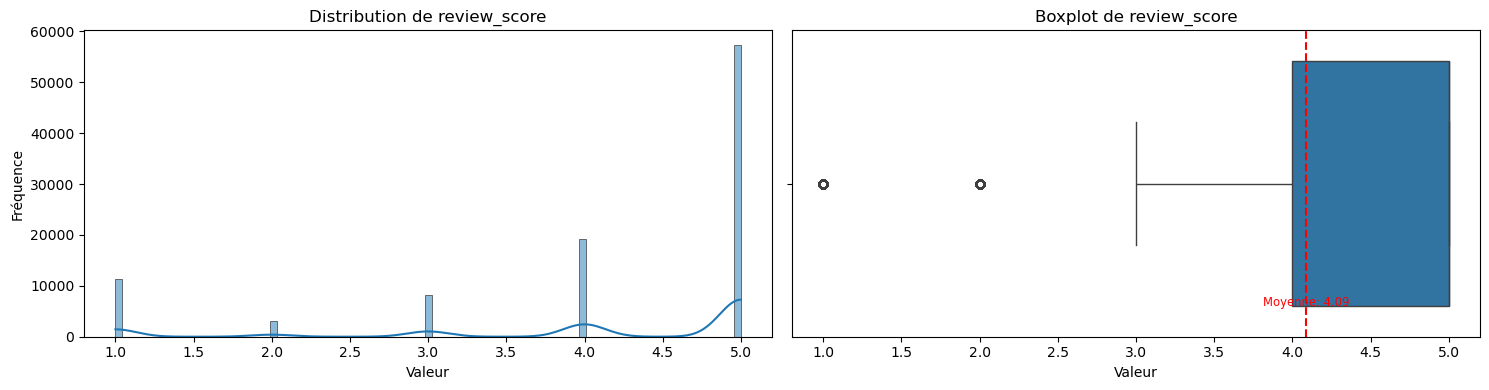

In [57]:
# Pour une seule colonne numérique (review_score)
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Histogramme avec courbe de densité (KDE)
sns.histplot(order_reviews_df['review_score'].dropna(), kde=True, ax=axes[0])
axes[0].set_title('Distribution de review_score')
axes[0].set_xlabel('Valeur')
axes[0].set_ylabel('Fréquence')

# Boxplot
sns.boxplot(x=order_reviews_df['review_score'].dropna(), ax=axes[1])
axes[1].set_title('Boxplot de review_score')
axes[1].set_xlabel('Valeur')

# Ajouter les statistiques sur le boxplot
mean_val = order_reviews_df['review_score'].mean()
axes[1].axvline(mean_val, color='r', linestyle='--')
axes[1].text(mean_val, 0.1, f'Moyenne: {mean_val:.2f}', 
            horizontalalignment='center', size='small', 
            color='red', transform=axes[1].get_xaxis_transform())

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()
plt.close()

Visualisation détaillée de la distribution des scores d'avis clients, révélant une forte asymétrie vers les notes élevées avec une moyenne de 4,09/5, information cruciale pour l'analyse de satisfaction.

In [58]:
# Convertir les colonnes de dates en format datetime
review_date_columns = ['review_creation_date']
for col in review_date_columns:
    if col in order_reviews_df.columns:
        order_reviews_df[col] = pd.to_datetime(order_reviews_df[col])

Conversion de la colonne de date des avis au format datetime pour permettre des analyses temporelles de l'évolution de la satisfaction client.

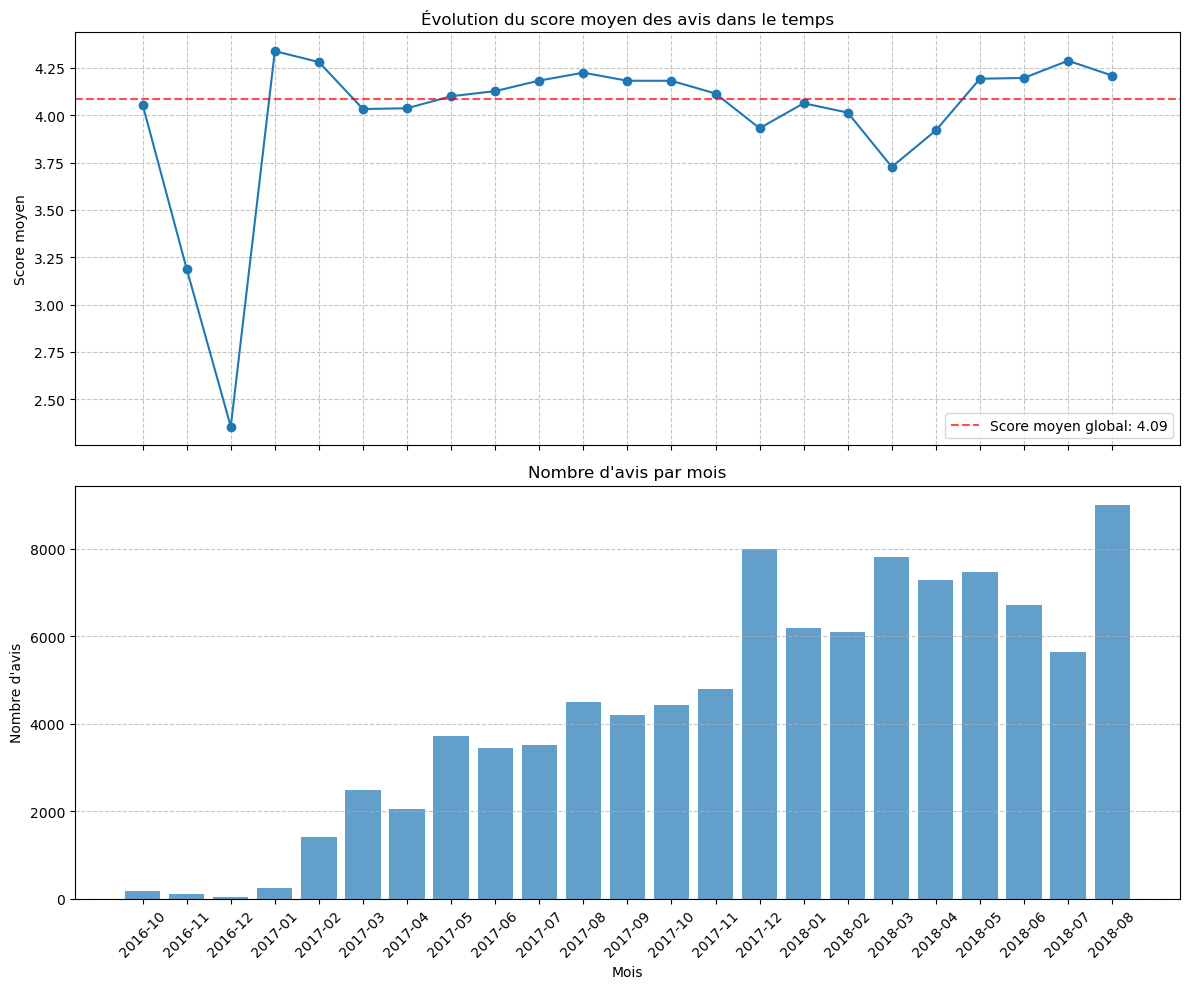

In [59]:
# Évolution des scores dans le temps

# Créer une colonne pour le mois-année
order_reviews_df['review_month'] = order_reviews_df['review_creation_date'].dt.to_period('M')

# Calculer le score moyen par mois
monthly_scores = order_reviews_df.groupby('review_month')['review_score'].agg(['mean', 'count']).reset_index()
monthly_scores['review_month'] = monthly_scores['review_month'].astype(str)

# Créer une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Graphique 1: Score moyen par mois
ax1.plot(monthly_scores['review_month'], monthly_scores['mean'], marker='o', linestyle='-')
ax1.set_title('Évolution du score moyen des avis dans le temps')
ax1.set_ylabel('Score moyen')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.axhline(y=order_reviews_df['review_score'].mean(), color='r', linestyle='--', alpha=0.7, 
            label=f'Score moyen global: {order_reviews_df["review_score"].mean():.2f}')
ax1.legend()

# Rotation des labels sur l'axe x
plt.xticks(rotation=45)

# Graphique 2: Nombre d'avis par mois
ax2.bar(monthly_scores['review_month'], monthly_scores['count'], alpha=0.7)
ax2.set_title('Nombre d\'avis par mois')
ax2.set_xlabel('Mois')
ax2.set_ylabel('Nombre d\'avis')
ax2.grid(True, linestyle='--', alpha=0.7, axis='y')

# Ajuster l'espacement
plt.tight_layout()
plt.show()
plt.close()

Analyse de l'évolution temporelle des évaluations clients, montrant à la fois le score moyen mensuel et le volume d'avis, permettant d'identifier les tendances et les éventuelles saisonnalités dans la satisfaction client.

## products_df

In [60]:
print("\nInformations sur la structure:")
print(products_df.info())
print("\nAperçu des données produits:")
print(products_df.head())


Informations sur la structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       32951 non-null  int64  
 1   product_id                  32951 non-null  object 
 2   product_category_name       32341 non-null  object 
 3   product_name_lenght         32341 non-null  float64
 4   product_description_lenght  32341 non-null  float64
 5   product_photos_qty          32341 non-null  float64
 6   product_weight_g            32949 non-null  float64
 7   product_length_cm           32949 non-null  float64
 8   product_height_cm           32949 non-null  float64
 9   product_width_cm            32949 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ MB
None

Aperçu des données produits:
   index                        product_id  product_category_name  \
0      0 

Exploration de la structure et des premiers enregistrements de la table des produits, aperçu des caractéristiques disponibles pour l'analyse des articles vendus sur la plateforme.

In [61]:
products_df.describe()

,index,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951.000000,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,16475.000000,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,9512.278697,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,8237.500000,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,16475.000000,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,24712.500000,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,32950.000000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


Analyse statistique des caractéristiques des produits, incluant leurs dimensions, poids et nombre de photos, pour comprendre la diversité de l'offre sur la plateforme.

In [62]:
# Analyse des valeurs manquantes dans products_df
print("\nValeurs manquantes dans products_df avant traitement:")
missing_values = products_df.isnull().sum()
print(missing_values)
missing_percentage = (missing_values / len(products_df)) * 100
print("\nPourcentage de valeurs manquantes:")
print(missing_percentage.round(2))

# Traitement des valeurs manquantes par colonne
# 1. product_category_name
if products_df['product_category_name'].isnull().sum() > 0:
    missing_count = products_df['product_category_name'].isnull().sum()
    products_df['product_category_name'] = products_df['product_category_name'].fillna('unknown')
    print(f"\nImputation de {missing_count} valeurs manquantes dans product_category_name par 'unknown'")

# 2. product_name_lenght, product_description_lenght, product_photos_qty
for col in ['product_name_lenght', 'product_description_lenght', 'product_photos_qty']:
    if col in products_df.columns and products_df[col].isnull().sum() > 0:
        missing_count = products_df[col].isnull().sum()
        median_val = products_df[col].median()
        products_df[col] = products_df[col].fillna(median_val)
        print(f"Imputation de {missing_count} valeurs manquantes dans {col} par la médiane ({median_val})")

# 3. Dimensions et poids
for col in ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']:
    if products_df[col].isnull().sum() > 0:
        missing_count = products_df[col].isnull().sum()
        median_val = products_df[col].median()
        products_df[col] = products_df[col].fillna(median_val)
        print(f"Imputation de {missing_count} valeurs manquantes dans {col} par la médiane ({median_val})")

# Vérification après imputation
print("\nValeurs manquantes dans products_df après traitement:")
print(products_df.isnull().sum())

# Vérification des types de données après imputation
print("\nTypes de données après imputation:")
print(products_df.dtypes)


Valeurs manquantes dans products_df avant traitement:
index                           0
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Pourcentage de valeurs manquantes:
index                         0.00
product_id                    0.00
product_category_name         1.85
product_name_lenght           1.85
product_description_lenght    1.85
product_photos_qty            1.85
product_weight_g              0.01
product_length_cm             0.01
product_height_cm             0.01
product_width_cm              0.01
dtype: float64

Imputation de 610 valeurs manquantes dans product_category_name par 'unknown'
Imputation de 610 valeurs manquantes dans product_name_lenght par la médiane (51.0)
Imputation de 610 valeurs ma

Identification de 2 448 valeurs manquantes dans la table des produits, nécessitant une attention particulière lors du prétraitement pour éviter les biais dans l'analyse.

In [63]:
print(products_df.duplicated().sum())

0


Vérification de l'absence de doublons dans la table des produits, confirmant que chaque produit est uniquement identifié dans le dataset.

In [64]:
category_counts = products_df['product_category_name'].value_counts()
print(category_counts)

product_category_name
cama_mesa_banho                  3029
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
fashion_roupa_infanto_juvenil       5
casa_conforto_2                     5
pc_gamer                            3
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: count, Length: 74, dtype: int64


Analyse de la distribution des produits par catégorie, révélant les types d'articles les plus représentés sur la plateforme, une information précieuse pour comprendre l'offre d'Olist.

In [65]:
products_df = products_df.drop(['index', 'product_name_lenght', 'product_description_lenght'], axis=1)#non pertinent pour la segmentation

Simplification du DataFrame des produits en éliminant les colonnes peu pertinentes pour la segmentation client, se concentrant sur les caractéristiques physiques et la catégorie des produits.

## sellers_df

In [66]:
print("\nInformations sur la structure:")
print(sellers_df.info())
print("\nAperçu des données :")
print(sellers_df.head())


Informations sur la structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   3095 non-null   int64 
 1   seller_id               3095 non-null   object
 2   seller_zip_code_prefix  3095 non-null   int64 
 3   seller_city             3095 non-null   object
 4   seller_state            3095 non-null   object
dtypes: int64(2), object(3)
memory usage: 121.0+ KB
None

Aperçu des données :
   index                         seller_id  seller_zip_code_prefix  \
0      0  3442f8959a84dea7ee197c632cb2df15                   13023   
1      1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2      2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3      3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4      4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

Exploration de la structure et des premières entrées de la table des vendeurs, donnant un aperçu des partenaires commerciaux d'Olist et de leur distribution géographique.

In [67]:
sellers_df.describe()

,index,seller_zip_code_prefix
count,3095.000000,3095.000000
mean,1547.000000,32291.059451
std,893.593867,32713.453830
min,0.000000,1001.000000
25%,773.500000,7093.500000
50%,1547.000000,14940.000000
75%,2320.500000,64552.500000
max,3094.000000,99730.000000


Analyse statistique des variables numériques de la table des vendeurs, principalement les codes postaux, permettant d'identifier les tendances centrales de leur distribution.

In [68]:
total_missing = sellers_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes: {total_missing}")

Nombre total de valeurs manquantes: 0


Vérification de l'absence de valeurs manquantes dans la table des vendeurs, confirmant la qualité des données pour cette dimension.

In [69]:
print(sellers_df.duplicated().sum())

0


Confirmation de l'absence de doublons dans la table des vendeurs, garantissant que chaque partenaire commercial est uniquement identifié dans la base de données.

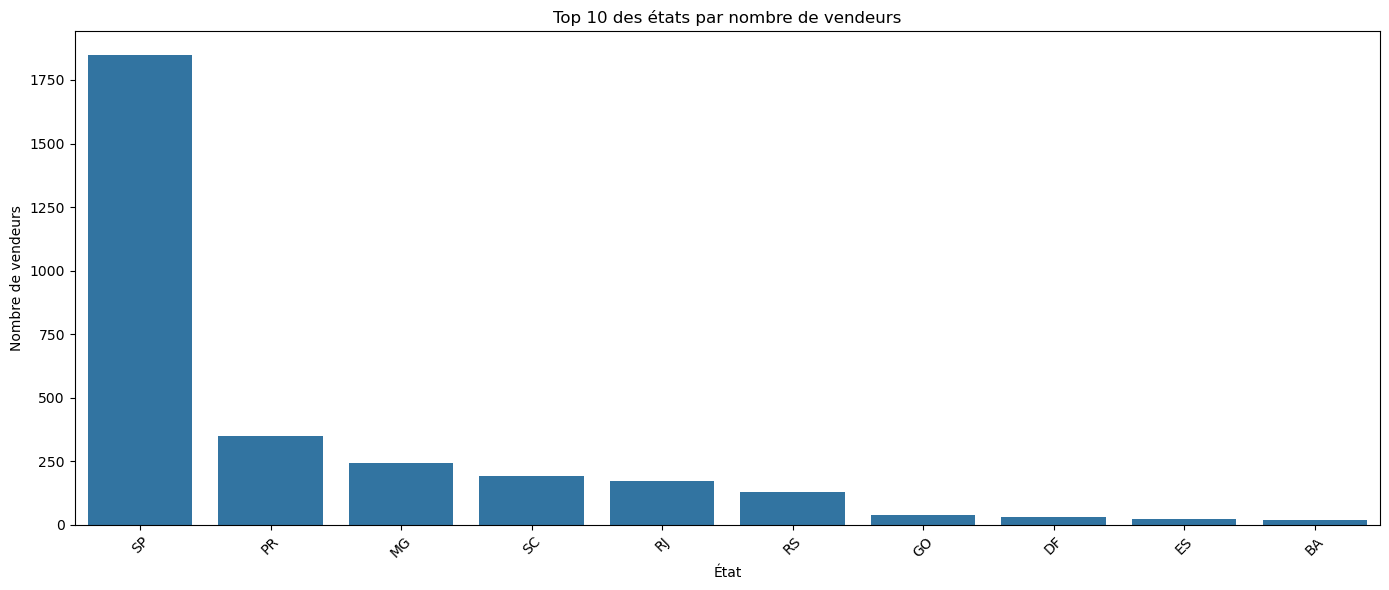

In [70]:
# Distribution géographique des vendeurs
seller_states = sellers_df['seller_state'].value_counts().reset_index()
seller_states.columns = ['state', 'count']

plt.figure(figsize=(14, 6))
sns.barplot(x='state', y='count', data=seller_states.head(10))
plt.title('Top 10 des états par nombre de vendeurs')
plt.xlabel('État')
plt.ylabel('Nombre de vendeurs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

Visualisation de la distribution géographique des vendeurs par état, permettant d'identifier les zones de forte présence commerciale et les opportunités d'expansion potentielles.

In [71]:
sellers_df = sellers_df.drop('index', axis=1)

Simplification du DataFrame des vendeurs en supprimant la colonne d'index redondante, optimisant la structure pour les analyses ultérieures.

## geoloc_df

In [72]:
print("\nInformations sur la structure:")
print(geoloc_df.info())
print("\nAperçu des données :")
print(geoloc_df.head())


Informations sur la structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 6 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   index                        1000163 non-null  int64  
 1   geolocation_zip_code_prefix  1000163 non-null  int64  
 2   geolocation_lat              1000163 non-null  float64
 3   geolocation_lng              1000163 non-null  float64
 4   geolocation_city             1000163 non-null  object 
 5   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 45.8+ MB
None

Aperçu des données :
   index  geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0      0                         1037       -23.545621       -46.639292   
1      1                         1046       -23.546081       -46.644820   
2      2                         1046       -23.546129       

Exploration de la structure et des premières entrées de la table de géolocalisation, fournissant les coordonnées des codes postaux pour l'analyse géographique des clients et vendeurs.

In [73]:
geoloc_df.describe()

,index,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1.000163e+06,1.000163e+06,1.000163e+06,1.000163e+06
mean,5.000810e+05,3.657417e+04,-2.117615e+01,-4.639054e+01
std,2.887223e+05,3.054934e+04,5.715866e+00,4.269748e+00
min,0.000000e+00,1.001000e+03,-3.660537e+01,-1.014668e+02
25%,2.500405e+05,1.107500e+04,-2.360355e+01,-4.857317e+01
50%,5.000810e+05,2.653000e+04,-2.291938e+01,-4.663788e+01
75%,7.501215e+05,6.350400e+04,-1.997962e+01,-4.376771e+01
max,1.000162e+06,9.999000e+04,4.506593e+01,1.211054e+02


Analyse statistique des coordonnées géographiques (latitude, longitude) dans la table de géolocalisation, permettant d'identifier l'étendue de la couverture géographique d'Olist.

In [74]:
total_missing = geoloc_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes: {total_missing}")

Nombre total de valeurs manquantes: 0


Vérification de l'absence de valeurs manquantes dans la table de géolocalisation, confirmant la qualité des données pour cette dimension critique.

In [75]:
print(geoloc_df.duplicated().sum())

0


Confirmation de l'absence de doublons dans la table de géolocalisation, garantissant l'unicité des coordonnées pour chaque code postal.

In [76]:
geoloc_df = geoloc_df.drop('index', axis=1)

Simplification du DataFrame de géolocalisation en supprimant la colonne d'index redondante, optimisant la structure pour les analyses spatiales.

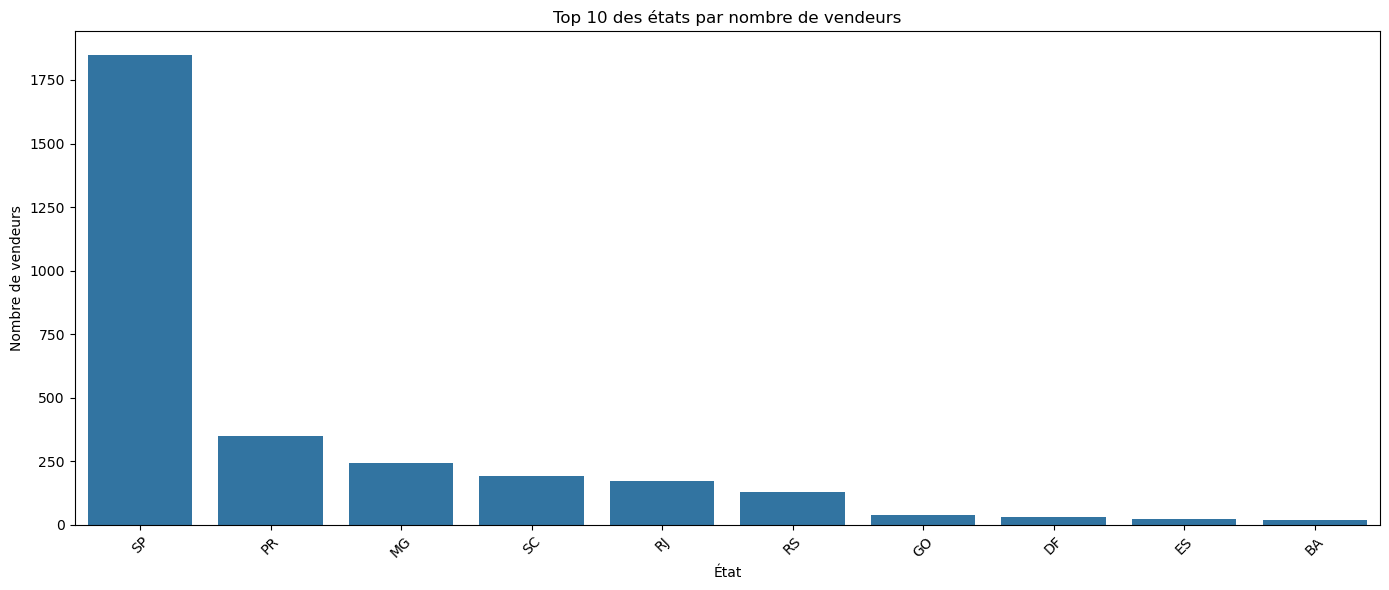

In [77]:
# Distribution géographique des vendeurs
seller_states = sellers_df['seller_state'].value_counts().reset_index()
seller_states.columns = ['state', 'count']

plt.figure(figsize=(14, 6))
sns.barplot(x='state', y='count', data=seller_states.head(10))
plt.title('Top 10 des états par nombre de vendeurs')
plt.xlabel('État')
plt.ylabel('Nombre de vendeurs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

Répétition de la visualisation de la distribution géographique des vendeurs, confirmant la concentration dans certains états brésiliens et fournissant une base pour l'analyse des distances client-vendeur.

## translation_df

In [78]:
print("\nInformations sur la structure:")
print(translation_df.info())
print("\nAperçu des données :")
print(translation_df.head())


Informations sur la structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          71 non-null     int64 
 1   product_category_name          71 non-null     object
 2   product_category_name_english  71 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.8+ KB
None

Aperçu des données :
   index   product_category_name product_category_name_english
0      0            beleza_saude                 health_beauty
1      1  informatica_acessorios         computers_accessories
2      2              automotivo                          auto
3      3         cama_mesa_banho                bed_bath_table
4      4        moveis_decoracao               furniture_decor


Exploration de la table de traduction des catégories de produits, permettant d'associer les noms de catégories portugais à leurs équivalents anglais pour une meilleure interprétation internationale.

In [79]:
total_missing = translation_df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes: {total_missing}")

Nombre total de valeurs manquantes: 0


Vérification de l'absence de valeurs manquantes dans la table de traduction, confirmant la complétude de ce dictionnaire de correspondance.

In [80]:
translation_df = translation_df.drop('index', axis=1)

Simplification du DataFrame de traduction en éliminant la colonne d'index redondante, optimisant sa structure avant utilisation dans les jointures.

# Jointures

## Jointure des tables liées aux commandes

In [81]:
# Afficher les infos avant jointure
print("Infos de orders_df:")
orders_df.info()
print("\nInfos de order_items_df:")
order_items_df.info()

# Joindre orders_df avec order_items_df
orders_items = orders_df.merge(order_items_df, on='order_id', how='left')
print("\nInfos après jointure avec order_items:")
orders_items.info()

Infos de orders_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  99441 non-null  object        
 1   customer_id               99441 non-null  object        
 2   order_status              99441 non-null  object        
 3   order_purchase_timestamp  99441 non-null  datetime64[ns]
 4   customer_delivery_time    99441 non-null  float64       
 5   total_delivery_time       99441 non-null  float64       
 6   delivery_delay            99441 non-null  float64       
 7   approval_time             99441 non-null  float64       
 8   carrier_delivery_time     99441 non-null  float64       
 9   is_delayed                99441 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(1), object(3)
memory usage: 7.2+ MB

Infos de order_items_df:
<class 'pandas.core.

Première étape de consolidation des données : jointure entre commandes et items de commande. Créer une vue détaillée des produits achetés dans chaque transaction.

In [82]:
# Analyse des valeurs manquantes après la jointure
print("\nVérification des valeurs manquantes après jointure orders_df + order_items_df:")
missing_values = orders_items.isnull().sum()
# Filtrer pour n'afficher que les colonnes avec des valeurs manquantes
missing_values = missing_values[missing_values > 0]
if len(missing_values) > 0:
    print(missing_values)
    print("\nPourcentage de valeurs manquantes:")
    missing_percentage = (missing_values / len(orders_items)) * 100
    print(missing_percentage.round(2))
    
    # Si des valeurs manquantes sont apparues après la jointure, elles doivent être traitées
    print("\nTraitement des nouvelles valeurs manquantes issues de la jointure:")
    for col in missing_values.index:
        # Traitement spécifique selon le type de colonne
        if col in ['order_item_id', 'product_id', 'seller_id']:
            # Pour les identifiants, on peut considérer qu'ils sont manquants parce que
            # la jointure n'a pas trouvé de correspondance - pas d'imputation simple possible
            print(f"- {col}: {missing_values[col]} valeurs manquantes dues à l'absence de correspondance dans la jointure")
        elif orders_items[col].dtype in ['int64', 'float64']:
            # Pour les valeurs numériques, imputation par la médiane
            median_val = orders_items[col].median()
            orders_items[col] = orders_items[col].fillna(median_val)
            print(f"- {col}: {missing_values[col]} valeurs manquantes imputées par la médiane ({median_val})")
        else:
            # Pour les valeurs catégorielles, imputation par la valeur la plus fréquente
            mode_val = orders_items[col].mode()[0]
            orders_items[col] = orders_items[col].fillna(mode_val)
            print(f"- {col}: {missing_values[col]} valeurs manquantes imputées par le mode ({mode_val})")
else:
    print("Aucune valeur manquante détectée après la jointure.")

# Vérification finale après traitement
missing_after = orders_items.isnull().sum()
missing_after = missing_after[missing_after > 0]
if len(missing_after) > 0:
    print("\nValeurs manquantes restantes après traitement:")
    print(missing_after)
else:
    print("\nToutes les valeurs manquantes ont été traitées.")


Vérification des valeurs manquantes après jointure orders_df + order_items_df:
order_item_id    775
product_id       775
seller_id        775
price            775
freight_value    775
freight_ratio    775
dtype: int64

Pourcentage de valeurs manquantes:
order_item_id    0.68
product_id       0.68
seller_id        0.68
price            0.68
freight_value    0.68
freight_ratio    0.68
dtype: float64

Traitement des nouvelles valeurs manquantes issues de la jointure:
- order_item_id: 775 valeurs manquantes dues à l'absence de correspondance dans la jointure
- product_id: 775 valeurs manquantes dues à l'absence de correspondance dans la jointure
- seller_id: 775 valeurs manquantes dues à l'absence de correspondance dans la jointure
- price: 775 valeurs manquantes imputées par la médiane (74.99)
- freight_value: 775 valeurs manquantes imputées par la médiane (16.26)
- freight_ratio: 775 valeurs manquantes imputées par la médiane (0.23135623826460017)

Valeurs manquantes restantes après tra

In [83]:
# Afficher les infos de order_payments_df avant jointure
print("\nInfos de order_payments_df:")
order_payments_df.info()

# Joindre avec order_payments_df
orders_items_payments = orders_items.merge(order_payments_df, on='order_id', how='left')
print("\nInfos après jointure avec order_payments:")
orders_items_payments.info()


Infos de order_payments_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB

Infos après jointure avec order_payments:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  118434 non-null  object        
 1   customer_id               118434 non-null  object        
 2   order_status            

Deuxième étape de consolidation : intégration des informations de paiement. Enrichir la vue des transactions avec les détails financiers (méthodes, échelonnements, montants).

In [84]:
# Afficher les infos de order_reviews_df avant jointure
print("\nInfos de order_reviews_df:")
order_reviews_df.info()

# Joindre avec order_reviews_df
orders_items_payments_reviews = orders_items_payments.merge(order_reviews_df, on='order_id', how='left')
print("\nInfos après jointure avec order_reviews:")
orders_items_payments_reviews.info()


Infos de order_reviews_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   order_id              99224 non-null  object        
 1   review_score          99224 non-null  int64         
 2   review_creation_date  99224 non-null  datetime64[ns]
 3   review_month          99224 non-null  period[M]     
dtypes: datetime64[ns](1), int64(1), object(1), period[M](1)
memory usage: 3.0+ MB

Infos après jointure avec order_reviews:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  119143 non-null  object        
 1   customer_id               119143 non-null  object        
 2   order_status           

Troisième étape de consolidation : intégration des avis clients. Associer la satisfaction aux caractéristiques des commandes et produits achetés.

In [85]:
# Analyse des valeurs manquantes après la jointure
print("\nVérification des valeurs manquantes après jointure orders_df + order_items_df + order_reviews :")
missing_values = orders_items.isnull().sum()
# Filtrer pour n'afficher que les colonnes avec des valeurs manquantes
missing_values = missing_values[missing_values > 0]
if len(missing_values) > 0:
    print(missing_values)
    print("\nPourcentage de valeurs manquantes:")
    missing_percentage = (missing_values / len(orders_items)) * 100
    print(missing_percentage.round(2))
    
    # Si des valeurs manquantes sont apparues après la jointure, elles doivent être traitées
    print("\nTraitement des nouvelles valeurs manquantes issues de la jointure:")
    for col in missing_values.index:
        # Traitement spécifique selon le type de colonne
        if col in ['order_item_id', 'product_id', 'seller_id']:
            # Pour les identifiants, on peut considérer qu'ils sont manquants parce que
            # la jointure n'a pas trouvé de correspondance - pas d'imputation simple possible
            print(f"- {col}: {missing_values[col]} valeurs manquantes dues à l'absence de correspondance dans la jointure")
        elif orders_items[col].dtype in ['int64', 'float64']:
            # Pour les valeurs numériques, imputation par la médiane
            median_val = orders_items[col].median()
            orders_items[col] = orders_items[col].fillna(median_val)
            print(f"- {col}: {missing_values[col]} valeurs manquantes imputées par la médiane ({median_val})")
        else:
            # Pour les valeurs catégorielles, imputation par la valeur la plus fréquente
            mode_val = orders_items[col].mode()[0]
            orders_items[col] = orders_items[col].fillna(mode_val)
            print(f"- {col}: {missing_values[col]} valeurs manquantes imputées par le mode ({mode_val})")
else:
    print("Aucune valeur manquante détectée après la jointure.")

# Vérification finale après traitement
missing_after = orders_items.isnull().sum()
missing_after = missing_after[missing_after > 0]
if len(missing_after) > 0:
    print("\nValeurs manquantes restantes après traitement:")
    print(missing_after)
else:
    print("\nToutes les valeurs manquantes ont été traitées.")


Vérification des valeurs manquantes après jointure orders_df + order_items_df + order_reviews :
order_item_id    775
product_id       775
seller_id        775
dtype: int64

Pourcentage de valeurs manquantes:
order_item_id    0.68
product_id       0.68
seller_id        0.68
dtype: float64

Traitement des nouvelles valeurs manquantes issues de la jointure:
- order_item_id: 775 valeurs manquantes dues à l'absence de correspondance dans la jointure
- product_id: 775 valeurs manquantes dues à l'absence de correspondance dans la jointure
- seller_id: 775 valeurs manquantes dues à l'absence de correspondance dans la jointure

Valeurs manquantes restantes après traitement:
order_item_id    775
product_id       775
seller_id        775
dtype: int64


## Informations produits

In [86]:
# Afficher les infos avant jointure avec products_df
print("\nInfos de products_df:")
products_df.info()

# Joindre avec products_df pour obtenir les catégories et caractéristiques des produits
orders_products = orders_items_payments_reviews.merge(products_df, on='product_id', how='left')
print("\nInfos après jointure avec products:")
orders_products.info()


Infos de products_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             32951 non-null  object 
 1   product_category_name  32951 non-null  object 
 2   product_photos_qty     32951 non-null  float64
 3   product_weight_g       32951 non-null  float64
 4   product_length_cm      32951 non-null  float64
 5   product_height_cm      32951 non-null  float64
 6   product_width_cm       32951 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.8+ MB

Infos après jointure avec products:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  119143 non-null  object        
 1   custome

Quatrième étape : enrichissement des données avec les caractéristiques des produits (catégorie, dimensions, poids). Intégrer une dimension qualitative à l'analyse des comportements d'achat.

In [87]:
# Afficher les infos avant jointure avec translation_df
print("\nInfos de translation_df:")
translation_df.info()

# Ajouter les traductions des catégories de produits
orders_products_translated = orders_products.merge(translation_df, on='product_category_name', how='left')
print("\nInfos après jointure avec translation:")
orders_products_translated.info()


Infos de translation_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB

Infos après jointure avec translation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   customer_delivery_time         1

Cinquième étape : ajout des traductions anglaises des catégories de produits. Faciliter l'interprétation des résultats.

In [88]:
# Afficher les infos avant jointure avec customers_df
print("\nInfos de customers_df:")
customers_df.info()

# Joindre avec customers_df
full_orders = orders_products_translated.merge(customers_df, on='customer_id', how='left')
print("\nInfos après jointure finale avec customers:")
full_orders.info()


Infos de customers_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB

Infos après jointure finale avec customers:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_s

Sixième étape : intégration des informations clients. Completer avec les caractéristiques démographiques et géographiques des acheteurs à leurs commandes.

In [89]:
# Afficher les infos avant jointure avec customers_df
print("\nInfos de sellers_df:")
sellers_df.info()

# Joindre sellers_df avec full_orders
full_orders = full_orders.merge(sellers_df, on='seller_id', how='left')
print("\nInfos après jointure finale avec customers:")
full_orders.info()



Infos de sellers_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB

Infos après jointure finale avec customers:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_pu

Septième étape : ajout des informations sur les vendeurs. Analyser les distances géographiques entre acheteurs et vendeurs (facteur important pour la satisfaction ?).

In [90]:
# La table geoloc_df contient des millions de lignes, nous devons d'abord l'agréger 
# Agrégation par code postal pour obtenir une seule entrée par code postal

# Pour les codes postaux des clients
geoloc_customers = geoloc_df.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',  # Latitude moyenne
    'geolocation_lng': 'mean'   # Longitude moyenne
}).reset_index()

# Renommer les colonnes pour les clients
geoloc_customers = geoloc_customers.rename(columns={
    'geolocation_zip_code_prefix': 'customer_zip_code_prefix',
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng'
})

# Pour les codes postaux des vendeurs
geoloc_sellers = geoloc_df.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',  # Latitude moyenne
    'geolocation_lng': 'mean'   # Longitude moyenne
}).reset_index()

# Renommer les colonnes pour les vendeurs
geoloc_sellers = geoloc_sellers.rename(columns={
    'geolocation_zip_code_prefix': 'seller_zip_code_prefix',
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng'
})

Préparation des données géographiques par agrégation des coordonnées par code postal. Créer des tables réduites pour les clients et vendeurs afin d'optimiser les jointures à venir.

In [91]:
# Joindre les coordonnées des clients
full_orders = full_orders.merge(geoloc_customers, on='customer_zip_code_prefix', how='left')

# Joindre les coordonnées des vendeurs
full_orders = full_orders.merge(geoloc_sellers, on='seller_zip_code_prefix', how='left')

# Vérification des valeurs manquantes dans les coordonnées géographiques
print("Valeurs manquantes dans les coordonnées géographiques après jointure:")
geo_cols = ['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']
print(full_orders[geo_cols].isnull().sum())

# Imputation des coordonnées manquantes par la médiane
for col in geo_cols:
    median_val = full_orders[col].median()
    full_orders[col] = full_orders[col].fillna(median_val)

print("Valeurs manquantes dans les coordonnées géographiques après imputation:")
print(full_orders[geo_cols].isnull().sum())

print("\nInfos après jointure finale avec geoloc:")
full_orders.info()


Valeurs manquantes dans les coordonnées géographiques après jointure:
customer_lat     322
customer_lng     322
seller_lat      1098
seller_lng      1098
dtype: int64
Valeurs manquantes dans les coordonnées géographiques après imputation:
customer_lat    0
customer_lng    0
seller_lat      0
seller_lng      0
dtype: int64

Infos après jointure finale avec geoloc:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   customer_delivery_time         119143 non-null  float64       
 5   total_delivery_time            119143 non-

Finalisation du dataset principal par l'ajout des coordonnées géographiques des clients et vendeurs, permettant le calcul des distances et l'analyse spatiale des transactions.

In [92]:
#Export pour l'étape 4
full_orders.to_csv('full_orders.csv', index=False)

Sauvegarde du dataset complet et consolidé pour utilisation dans l'étape suivante du projet, garantissant la persistance du travail de préparation des données.

# Feature Engineering

Features ici créés 

Features RFM (Récence, Fréquence, Montant)
- recence_scaled - Récence standardisée
- frequence_scaled - Fréquence standardisée
- montant_scaled - Montant standardisé

Satisfaction client
- avg_review_log_std - Score moyen d'évaluation standardisé (après transformation logarithmique)

Comportement d'achat
- avg_installments_log_std - Nombre moyen d'échelonnements de paiement standardisé
- credit_card - Proportion d'achats par carte de crédit
- weekend_purchase_ratio_std - Proportion d'achats le weekend standardisée

Livraison et service
- avg_delivery_time_log_std - Temps moyen de livraison standardisé

Géographie
- avg_distance_km_log_std - Distance moyenne client-vendeur standardisée

### Features RFM (Récence, Fréquence, Montant)

La segmentation RFM ou méthode RFM est une méthode de segmentation principalement développée à l'origine pour le ciblage marketing.
Elle prend en compte :
- la Récence (date de la dernière commande),
- la Fréquence des commandes et
- le Montant (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes.

La segmentation RFM permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque.

In [93]:
from datetime import datetime


# Récupérer la date la plus récente dans le dataset pour calculer la récence
latest_date = full_orders['order_purchase_timestamp'].max()

# Créer un dataframe pour les métriques RFM par client
rfm = full_orders.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (latest_date - x.max()).days,  # Récence (jours depuis dernier achat)
    'order_id': pd.Series.nunique,                                      # Fréquence (nombre de commandes)
    'payment_value': 'sum'                                              # Montant (valeur totale des achats)
})

# Renommer les colonnes
rfm.columns = ['recence', 'frequence', 'montant']

# Examiner les résultats
print("RFM metrics - first 5 rows:")
print(rfm.head())
print("\nRFM metrics - description:")
print(rfm.describe())

RFM metrics - first 5 rows:
                                  recence  frequence  montant
customer_unique_id                                           
0000366f3b9a7992bf8c76cfdf3221e2      160          1   141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      163          1    27.19
0000f46a3911fa3c0805444483337064      585          1    86.22
0000f6ccb0745a6a4b88665a16c9f078      369          1    43.62
0004aac84e0df4da2b147fca70cf8255      336          1   196.89

RFM metrics - description:
            recence     frequence        montant
count  96096.000000  96096.000000   96096.000000
mean     287.735691      1.034809     214.157343
std      153.414676      0.214384     644.891987
min        0.000000      1.000000       0.000000
25%      163.000000      1.000000      64.000000
50%      268.000000      1.000000     113.340000
75%      397.000000      1.000000     203.422500
max      772.000000     17.000000  109312.640000


Création des métriques RFM (Récence, Fréquence, Montant) essentielles pour la segmentation client en marketing, calculées par client à partir des données consolidées de commandes et paiements.

Récence (jours depuis le dernier achat) : En moyenne, le dernier achat des clients remonte à environ 9-10 mois mais certains clients ont acheté recemment (0 jours) à l'opposé d'autres n'ont pas achété depuis 772 jours (+ de 2 ans)
- Moyenne : 288 jours
- Médiane : 268 jours

Fréquence (nombre de commandes) : les clients n'ont passé qu'une seule commande (extreme haut = 17)
- Moyenne : 1,03 commande
- Médiane : 1 commande

Montant (valeur totale des achats en Réal brésilien) : il y a une forte dispersion avec une valeur extrème qui tire la moyenne en haut
- Moyenne : 214 R
- Médiane : 113 R

In [94]:
# Vérification des valeurs manquantes dans les métriques RFM
print("\nValeurs manquantes dans les métriques RFM:")
missing_rfm = rfm.isnull().sum()
print(missing_rfm)
missing_rfm_pct = (missing_rfm / len(rfm)) * 100
print("\nPourcentage de valeurs manquantes:")
print(missing_rfm_pct.round(2))

# Traitement des valeurs manquantes dans les métriques RFM
if missing_rfm.sum() > 0:
    print("\nTraitement des valeurs manquantes dans les métriques RFM:")
    
    # Pour la récence, imputer par la médiane
    if missing_rfm['recence'] > 0:
        median_recence = rfm['recence'].median()
        rfm['recence'] = rfm['recence'].fillna(median_recence)
        print(f"- recence: {missing_rfm['recence']} valeurs manquantes imputées par la médiane ({median_recence})")
    
    # Pour la fréquence, imputer par 1 (minimum observé, cas d'un client avec une seule commande)
    if missing_rfm['frequence'] > 0:
        rfm['frequence'] = rfm['frequence'].fillna(1)
        print(f"- frequence: {missing_rfm['frequence']} valeurs manquantes imputées par 1 (valeur minimale)")
    
    # Pour le montant, imputer par la médiane
    if missing_rfm['montant'] > 0:
        median_montant = rfm['montant'].median()
        rfm['montant'] = rfm['montant'].fillna(median_montant)
        print(f"- montant: {missing_rfm['montant']} valeurs manquantes imputées par la médiane ({median_montant})")
    
    # Vérification après imputation
    print("\nValeurs manquantes après imputation:")
    print(rfm.isnull().sum())
else:
    print("\nAucune valeur manquante dans les métriques RFM - pas d'imputation nécessaire.")

# Vérification des valeurs extrêmes et aberrantes
print("\nDétection de valeurs extrêmes dans les métriques RFM:")
for col in ['recence', 'frequence', 'montant']:
    Q1 = rfm[col].quantile(0.25)
    Q3 = rfm[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((rfm[col] < lower_bound) | (rfm[col] > upper_bound)).sum()
    outliers_pct = (outliers / len(rfm)) * 100
    print(f"- {col}: {outliers} valeurs extrêmes ({outliers_pct:.2f}%) détectées hors de l'intervalle [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    # Afficher quelques exemples de valeurs extrêmes
    if outliers > 0:
        extreme_values = rfm[(rfm[col] < lower_bound) | (rfm[col] > upper_bound)][col]
        print(f"  Exemples de valeurs extrêmes: {extreme_values.head(3).tolist()}")

print("\nNote: Les valeurs extrêmes sont conservées car elles peuvent être significatives pour la segmentation.")


Valeurs manquantes dans les métriques RFM:
recence      0
frequence    0
montant      0
dtype: int64

Pourcentage de valeurs manquantes:
recence      0.0
frequence    0.0
montant      0.0
dtype: float64

Aucune valeur manquante dans les métriques RFM - pas d'imputation nécessaire.

Détection de valeurs extrêmes dans les métriques RFM:
- recence: 4 valeurs extrêmes (0.00%) détectées hors de l'intervalle [-188.00, 748.00]
  Exemples de valeurs extrêmes: [764, 772, 762]
- frequence: 2997 valeurs extrêmes (3.12%) détectées hors de l'intervalle [1.00, 1.00]
  Exemples de valeurs extrêmes: [2, 2, 2]
- montant: 9432 valeurs extrêmes (9.82%) détectées hors de l'intervalle [-145.13, 412.56]
  Exemples de valeurs extrêmes: [838.36, 514.88, 1449.52]

Note: Les valeurs extrêmes sont conservées car elles peuvent être significatives pour la segmentation.


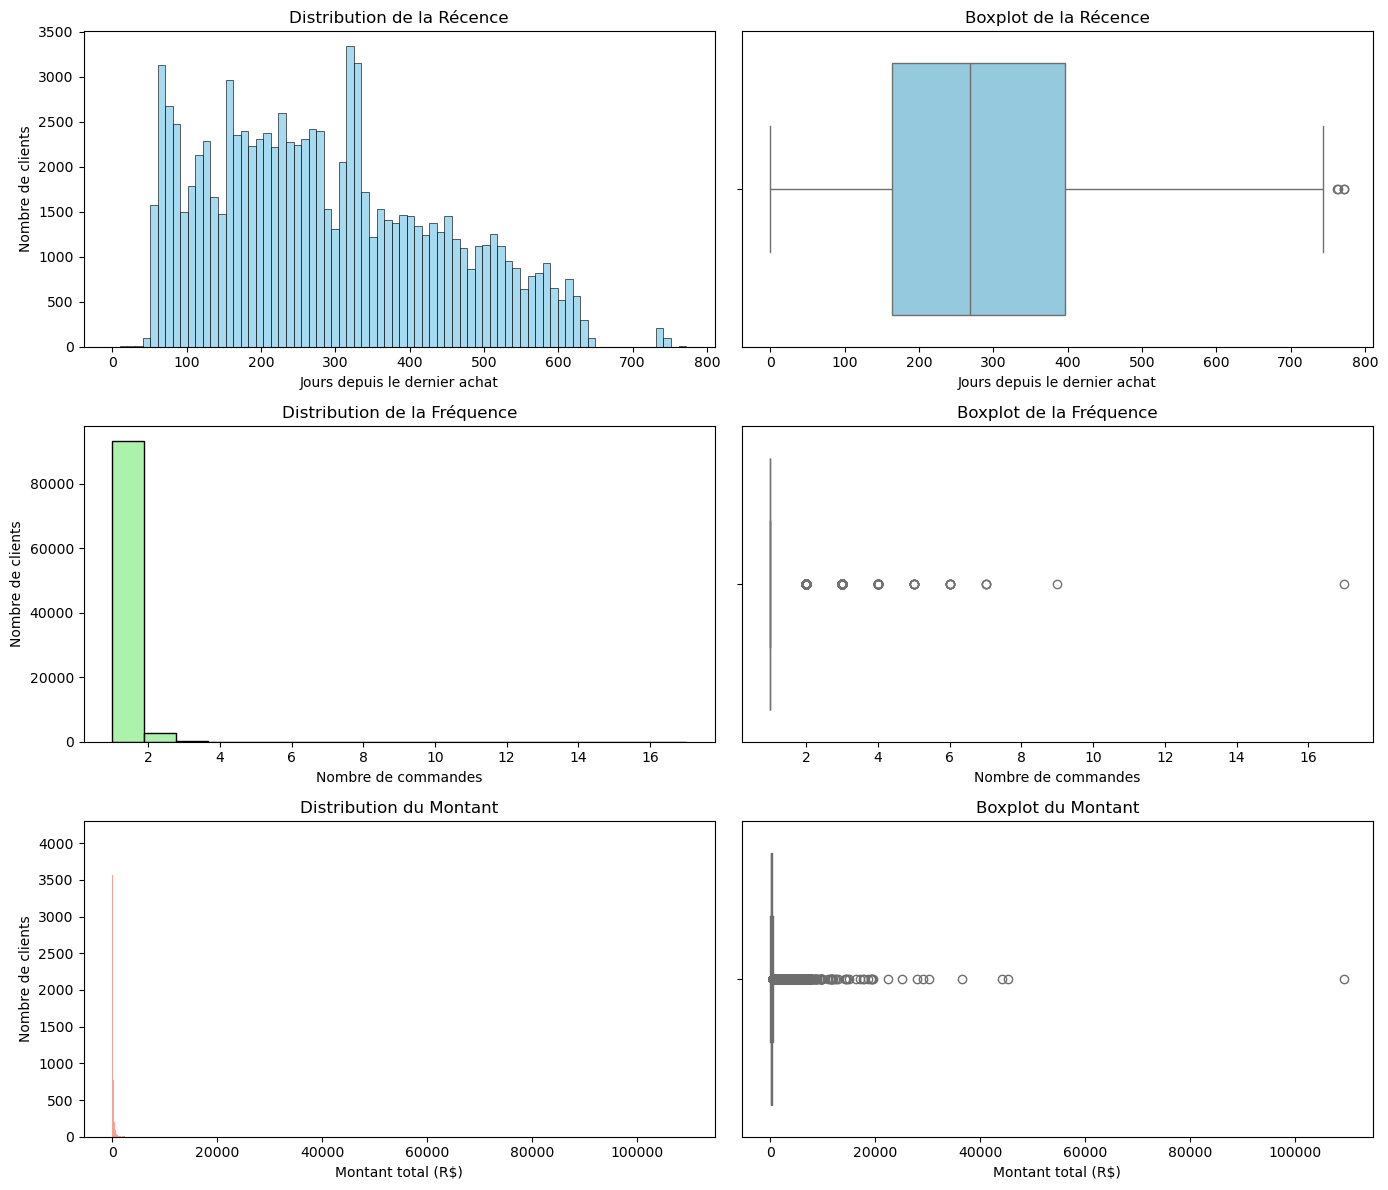

In [95]:
# Configurer figure pour les métriques
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Graphiques pour la Récence
# Histogramme
sns.histplot(rfm['recence'], kde=False, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution de la Récence')
axes[0, 0].set_xlabel('Jours depuis le dernier achat')
axes[0, 0].set_ylabel('Nombre de clients')

# Boxplot
sns.boxplot(x=rfm['recence'], ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Boxplot de la Récence')
axes[0, 1].set_xlabel('Jours depuis le dernier achat')

# Graphiques pour la Fréquence
# Histogramme
sns.histplot(rfm['frequence'], kde=False, ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Distribution de la Fréquence')
axes[1, 0].set_xlabel('Nombre de commandes')
axes[1, 0].set_ylabel('Nombre de clients')

# Boxplot
sns.boxplot(x=rfm['frequence'], ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Boxplot de la Fréquence')
axes[1, 1].set_xlabel('Nombre de commandes')

# Graphiques pour le Montant
# Histogramme
sns.histplot(rfm['montant'], kde=False, ax=axes[2, 0], color='salmon')
axes[2, 0].set_title('Distribution du Montant')
axes[2, 0].set_xlabel('Montant total (R$)')
axes[2, 0].set_ylabel('Nombre de clients')

# Boxplot
sns.boxplot(x=rfm['montant'], ax=axes[2, 1], color='salmon')
axes[2, 1].set_title('Boxplot du Montant')
axes[2, 1].set_xlabel('Montant total (R$)')

# Ajuster les espaces entre les graphiques
plt.tight_layout()
plt.show()
plt.close()

Visualisation détaillée des distributions des métriques RFM, révélant notamment une forte concentration de clients avec une seule commande et une distribution asymétrique des montants d'achat.

In [96]:
from sklearn.preprocessing import StandardScaler

# 1. Appliquer une transformation logarithmique au montant et à la fréquence
# Pour le montant, utiliser log1p pour gérer les zéros potentiels
rfm['montant_log'] = np.log1p(rfm['montant'])

# Pour la fréquence, soustraire 1 (car min=1) puis appliquer log1p
# Attention: si vous avez des fréquences = 0, ne pas soustraire 1
rfm['frequence_log'] = np.log1p(rfm['frequence'] - 1)  

# Conserver la récence telle quelle pour l'instant
rfm['recence_log'] = rfm['recence']  # Pas de transformation log pour la récence

# 2. Standardiser toutes les variables transformées (Z-score)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recence_log', 'frequence_log', 'montant_log']])

# Créer un dataframe avec les variables standardisées
rfm_transformed = pd.DataFrame(
    rfm_scaled, 
    columns=['recence_scaled', 'frequence_scaled', 'montant_scaled'],
    index=rfm.index
)

# Fusionner avec le dataframe original pour conserver toutes les informations
rfm_final = pd.concat([rfm, rfm_transformed], axis=1)

# Afficher les statistiques descriptives des variables transformées
print("Statistiques des variables transformées:")
print(rfm_transformed.describe())

Statistiques des variables transformées:
       recence_scaled  frequence_scaled  montant_scaled
count    9.609600e+04      9.609600e+04    9.609600e+04
mean     1.254038e-16     -2.617509e-17    1.064749e-17
std      1.000005e+00      1.000005e+00    1.000005e+00
min     -1.875552e+00     -1.756426e-01   -5.288138e+00
25%     -8.130665e-01     -1.756426e-01   -7.055772e-01
50%     -1.286435e-01     -1.756426e-01   -8.556255e-02
75%      7.122192e-01     -1.756426e-01    5.522616e-01
max      3.156587e+00      2.154330e+01    7.448286e+00


Transformation et standardisation des métriques RFM pour optimiser leur utilisation dans les algorithmes de clustering, incluant des transformations logarithmiques pour gérer les distributions asymétriques et une normalisation pour équilibrer leur influence.

### Features de satisfaction client

In [97]:
from sklearn.preprocessing import StandardScaler

# Version simplifiée des métriques de satisfaction - uniquement note moyenne
satisfaction = full_orders.groupby('customer_unique_id').agg({
    'review_score': ['mean']
})

# Aplatir les noms de colonnes multi-index
satisfaction.columns = ['_'.join(col).strip() for col in satisfaction.columns.values]

# Renommer pour plus de clarté
satisfaction.rename(columns={
    'review_score_mean': 'avg_review'
}, inplace=True)

# Statistiques descriptives des données originales
print("Statistiques des données originales:")
print(satisfaction.describe())

# Étape 1: Transformation logarithmique pour la note moyenne
# Pour avg_review, ajouter 1 pour éviter les problèmes avec les zéros (si présents)
satisfaction['avg_review_log'] = np.log1p(satisfaction['avg_review'])

# Statistiques après transformation logarithmique
print("\nStatistiques après transformation logarithmique:")
print(satisfaction[['avg_review_log']].describe())

# Étape 2: Standardisation des variables transformées
scaler = StandardScaler()

# Sélection des variables à standardiser
features_to_scale = ['avg_review_log']

# Application de la standardisation (avec gestion des valeurs NaN si nécessaire)
# Filtrer les lignes avec des valeurs NaN
satisfaction_valid = satisfaction[features_to_scale].dropna()
scaled_features = scaler.fit_transform(satisfaction_valid)

# Création d'un DataFrame avec les variables standardisées
# Utiliser le même index que les lignes valides utilisées pour le scaling
satisfaction_scaled = pd.DataFrame(
    scaled_features, 
    columns=['avg_review_log_std'],
    index=satisfaction_valid.index
)

# Fusionner avec le dataframe original
satisfaction_final = pd.concat([satisfaction, satisfaction_scaled], axis=1)

# Statistiques des variables transformées et standardisées
print("\nStatistiques après standardisation:")
print(satisfaction_scaled.describe())

# Vérification que les variables standardisées ont bien une moyenne ~ 0 et écart-type ~ 1
print("\nMoyenne des variables standardisées:")
print(satisfaction_scaled.mean())
print("\nÉcart-type des variables standardisées:")
print(satisfaction_scaled.std())

# Imputation des valeurs manquantes dans les métriques de satisfaction
print("Valeurs manquantes dans les métriques de satisfaction avant imputation:")
print(satisfaction_final.isnull().sum())

# Imputer la moyenne pour avg_review car c'est la mesure de tendance centrale la plus représentative
satisfaction_final['avg_review'] = satisfaction_final['avg_review'].fillna(satisfaction_final['avg_review'].mean())

# Recalculer la transformation logarithmique pour les valeurs imputées
satisfaction_final['avg_review_log'] = np.log1p(satisfaction_final['avg_review'])

# Pour avg_review_log_std, imputer par 0 (neutralité après standardisation)
satisfaction_final['avg_review_log_std'] = satisfaction_final['avg_review_log_std'].fillna(0)

print("Valeurs manquantes dans les métriques de satisfaction après imputation:")
print(satisfaction_final.isnull().sum())

Statistiques des données originales:
         avg_review
count  95380.000000
mean       4.084696
std        1.342024
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000

Statistiques après transformation logarithmique:
       avg_review_log
count    95380.000000
mean         1.574834
std          0.354549
min          0.693147
25%          1.609438
50%          1.791759
75%          1.791759
max          1.791759

Statistiques après standardisation:
       avg_review_log_std
count        9.538000e+04
mean         1.358509e-15
std          1.000005e+00
min         -2.486794e+00
25%          9.760111e-02
50%          6.118385e-01
75%          6.118385e-01
max          6.118385e-01

Moyenne des variables standardisées:
avg_review_log_std    1.358509e-15
dtype: float64

Écart-type des variables standardisées:
avg_review_log_std    1.000005
dtype: float64
Valeurs manquantes dans les métriques de satisfaction avant imputation:
avg_review       

Traitement des données de satisfaction client avec transformation logarithmique et standardisation, permettant d'intégrer cette dimension cruciale dans le modèle de segmentation avec un poids équilibré.

La feature a été  transformée et standardisée afin d'etre combinée aux autres features  pour créer votre dataset final de segmentation. Par la standardisation, les variables auront un poids comparable dans l'algorithme de clustering ainsi les segments seront équilibrés et significatifs.

Données originales (avg_review):
 -La note moyenne est élevée (4.08/5)
- La médiane est à 5, indiquant que plus de la moitié des clients donnent la note maximale
- Distribution très concentrée vers les valeurs élevées (75% donnent 4 ou 5 étoiles)


Transformation logarithmique (avg_review_log):
- A compressé la plage de valeurs (de1-5 à 0.69-1.79)
- l'asymétrie a legerement diminué

Standardisation finale (avg_review_log_std): 
- Moyenne exactement à zéro (1.36e-15 =env 0)
- Écart-type exactement à 1

### Features de comportement d'achat

In [98]:
def calculer_prix_moyen(full_orders):
    comportement_achat = full_orders.groupby('customer_unique_id')['price'].mean().reset_index()
    comportement_achat = comportement_achat.rename(columns={'price': 'avg_product_price'})
    comportement_achat = comportement_achat.set_index('customer_unique_id')
    return comportement_achat


Définition d'une fonction pour calculer le prix moyen des produits achetés par chaque client, une variable comportementale importante pour identifier les segments premium.

In [99]:
def calculer_taille_panier(full_orders):
    order_items = full_orders.groupby(['customer_unique_id', 'order_id']).size().reset_index(name='items_count')
    avg_basket = order_items.groupby('customer_unique_id')['items_count'].mean().reset_index()
    avg_basket = avg_basket.set_index('customer_unique_id')
    return avg_basket['items_count']


Définition d'une fonction pour calculer la taille moyenne du panier par client, permettant d'identifier les comportements d'achat en volume versus en valeur unitaire.

In [100]:
def calculer_distribution_jours_categoriel(full_orders):
    if 'order_purchase_timestamp' in full_orders.columns:
        if not pd.api.types.is_datetime64_any_dtype(full_orders['order_purchase_timestamp']):
            full_orders['order_purchase_timestamp'] = pd.to_datetime(full_orders['order_purchase_timestamp'])

        full_orders['weekday'] = full_orders['order_purchase_timestamp'].dt.weekday

        # One-hot encoding des jours de la semaine
        jours_semaine = pd.get_dummies(full_orders['weekday'], prefix='day')
        jours_semaine['customer_unique_id'] = full_orders['customer_unique_id']

        # Agrégation par client
        jours_semaine_grouped = jours_semaine.groupby('customer_unique_id').sum()

        return jours_semaine_grouped
    return pd.DataFrame()


Création d'une fonction pour analyser la distribution des achats par jour de la semaine pour chaque client, identifiant les préférences temporelles à travers un encodage one-hot.

In [101]:
def calculer_distribution_heures_categoriel(full_orders):
    if 'order_purchase_timestamp' in full_orders.columns:
        full_orders['hour'] = full_orders['order_purchase_timestamp'].dt.hour

        # Définition des périodes de la journée
        bins = [0, 6, 12, 18, 24]
        labels = ['night', 'morning', 'afternoon', 'evening']
        full_orders['time_period'] = pd.cut(full_orders['hour'], bins=bins, labels=labels, right=False)

        # One-hot encoding des périodes de la journée
        heures_journee = pd.get_dummies(full_orders['time_period'], prefix='hour')
        heures_journee['customer_unique_id'] = full_orders['customer_unique_id']

        # Agrégation par client
        heures_journee_grouped = heures_journee.groupby('customer_unique_id').sum()

        return heures_journee_grouped
    return pd.DataFrame()


Développement d'une fonction pour analyser la distribution des achats par période de la journée, segmentant les 24 heures en quatre plages horaires significatives (nuit, matin, après-midi, soir).

In [102]:
def calculer_saisonnalite_mensuelle_categoriel(full_orders):
    if 'order_purchase_timestamp' in full_orders.columns:
        full_orders['month'] = full_orders['order_purchase_timestamp'].dt.month

        # One-hot encoding des mois
        mois = pd.get_dummies(full_orders['month'], prefix='month')
        mois['customer_unique_id'] = full_orders['customer_unique_id']

        # Agrégation par client
        mois_grouped = mois.groupby('customer_unique_id').sum()

        return mois_grouped
    return pd.DataFrame()


Implémentation d'une fonction pour analyser la saisonnalité mensuelle des achats par client, permettant d'identifier les préférences saisonnières à travers un encodage one-hot des mois.

In [103]:
def transformer_et_standardiser(comportement_achat):
    # Transformation logarithmique pour les variables numériques
    comportement_achat['avg_product_price_log'] = np.log1p(comportement_achat['avg_product_price'])
    comportement_achat['avg_basket_items_log'] = np.log1p(comportement_achat['avg_basket_items'])

    scaler = StandardScaler()

    # Sélection des features numériques à standardiser
    numeric_features = ['avg_product_price_log', 'avg_basket_items_log']

    # Standardisation des variables numériques transformées
    scaled_numeric = scaler.fit_transform(comportement_achat[numeric_features])
    comportement_achat_scaled = pd.DataFrame(
        scaled_numeric,
        columns=[f'{col}_std' for col in numeric_features],
        index=comportement_achat.index
    )

    # Ajout des colonnes catégorielles sans transformation
    categorical_features = [col for col in comportement_achat.columns if col.startswith(('day_', 'hour_', 'month_'))]
    comportement_achat_scaled = comportement_achat_scaled.join(comportement_achat[categorical_features])

    return comportement_achat_scaled


Création d'une fonction pour transformer et standardiser les variables de comportement d'achat, assurant leur comparabilité dans le modèle de clustering tout en préservant les variables catégorielles.

In [104]:
def integrer_dans_clustering(comportement_achat_scaled, rfm_final=None, satisfaction_final=None):
    clustering_data = pd.DataFrame(index=comportement_achat_scaled.index)

    if rfm_final is not None:
        for col in ['recence_scaled', 'frequence_scaled', 'montant_scaled']:
            if col in rfm_final.columns:
                clustering_data[col] = rfm_final.loc[clustering_data.index, col]

    if satisfaction_final is not None and 'avg_review_log_std' in satisfaction_final.columns:
        clustering_data = clustering_data.join(satisfaction_final[['avg_review_log_std']], how='left')

    clustering_data = clustering_data.join(comportement_achat_scaled, how='left')

    return clustering_data


Définition d'une fonction pour assembler les différentes dimensions du comportement client (RFM, satisfaction, comportement d'achat) en un dataset unique prêt pour le clustering.

In [105]:
def verifier_resultats(clustering_data):
    print("\nDimensions du dataframe final pour clustering:")
    print(clustering_data.shape)

    print("\nAperçu du dataframe final:")
    print(clustering_data.head())

    print("\nNombre de valeurs manquantes par colonne:")
    print(clustering_data.isna().sum())


Création d'une fonction de vérification pour s'assurer de la qualité et de la complétude du dataset final avant le clustering, en identifiant notamment les valeurs manquantes potentielles.

In [106]:
# Utilisation des fonctions
comportement_achat = calculer_prix_moyen(full_orders)
comportement_achat['avg_basket_items'] = calculer_taille_panier(full_orders)

# Ajout des features catégorielles
comportement_achat = comportement_achat.join(calculer_distribution_jours_categoriel(full_orders), how='left')
comportement_achat = comportement_achat.join(calculer_distribution_heures_categoriel(full_orders), how='left')
comportement_achat = comportement_achat.join(calculer_saisonnalite_mensuelle_categoriel(full_orders), how='left')

comportement_achat = comportement_achat.fillna(0).replace([np.inf, -np.inf], 0)

comportement_achat_scaled = transformer_et_standardiser(comportement_achat)
clustering_data = integrer_dans_clustering(comportement_achat_scaled, rfm_final, satisfaction_final)
verifier_resultats(clustering_data)



Dimensions du dataframe final pour clustering:
(96096, 29)

Aperçu du dataframe final:
                                  recence_scaled  frequence_scaled  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2       -0.832621         -0.175643   
0000b849f77a49e4a4ce2b2a4ca5be3f       -0.813067         -0.175643   
0000f46a3911fa3c0805444483337064        1.937662         -0.175643   
0000f6ccb0745a6a4b88665a16c9f078        0.529706         -0.175643   
0004aac84e0df4da2b147fca70cf8255        0.314602         -0.175643   

                                  montant_scaled  avg_review_log_std  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2        0.159208            0.611839   
0000b849f77a49e4a4ce2b2a4ca5be3f       -1.622685            0.097601   
0000f46a3911fa3c0805444483337064       -0.382779           -0.531775   
0000f6ccb0745a6a4b88665a16c9f078       -1.118568            0

Application de toutes les fonctions définies précédemment pour créer un ensemble complet de features comportementales, incluant le prix moyen, la taille du panier et les distributions temporelles, puis assemblage dans un dataset final pour le clustering.

### Features de livraison et service

In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Calculer les métriques de livraison par client
livraison_service = full_orders.groupby('customer_unique_id').agg({
    'total_delivery_time': 'mean',  # Délai de livraison moyen (jours)
})

# Renommer la colonne
livraison_service.rename(columns={
    'total_delivery_time': 'avg_delivery_time'
}, inplace=True)

# Calcul du ratio des frais de livraison par rapport au montant total
temp_df = full_orders[['customer_unique_id', 'freight_value', 'payment_value']].copy()
temp_df = temp_df[temp_df['payment_value'] > 0]
temp_df['ratio'] = temp_df['freight_value'] / temp_df['payment_value']
freight_ratio = temp_df.groupby('customer_unique_id')['ratio'].mean()
livraison_service['freight_ratio'] = freight_ratio

# Transformation logarithmique pour les deux variables
livraison_service['avg_delivery_time_log'] = np.log1p(livraison_service['avg_delivery_time'])
livraison_service['freight_ratio'] = livraison_service['freight_ratio'].clip(0, 1)

# Imputation des valeurs manquantes avant la standardisation
imputer = SimpleImputer(strategy='median')
livraison_imputed = imputer.fit_transform(livraison_service[['avg_delivery_time_log', 'freight_ratio']])

# Standardisation des deux variables
scaler = StandardScaler()
scaled_features = scaler.fit_transform(livraison_imputed)

# Création du DataFrame avec les variables standardisées
livraison_scaled = pd.DataFrame(
    scaled_features,
    columns=['avg_delivery_time_log_std', 'freight_ratio_std'],
    index=livraison_service.index
)

# Vérification des valeurs manquantes après imputation et standardisation
print("Valeurs manquantes dans les métriques de livraison après imputation et standardisation:")
print(livraison_scaled.isnull().sum())

# Fusion avec le dataframe de clustering existant
clustering_data = clustering_data.join(livraison_scaled, how='left')

# Affichage du résultat
print("\nDimensions du dataframe final pour clustering:")
print(clustering_data.shape)
print("\nAperçu du dataframe final avec les variables de livraison:")
print(clustering_data.head())
print("\nNombre de valeurs manquantes dans les nouvelles colonnes:")
print(clustering_data[['avg_delivery_time_log_std', 'freight_ratio_std']].isna().sum())

Valeurs manquantes dans les métriques de livraison après imputation et standardisation:
avg_delivery_time_log_std    0
freight_ratio_std            0
dtype: int64

Dimensions du dataframe final pour clustering:
(96096, 31)

Aperçu du dataframe final avec les variables de livraison:
                                  recence_scaled  frequence_scaled  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2       -0.832621         -0.175643   
0000b849f77a49e4a4ce2b2a4ca5be3f       -0.813067         -0.175643   
0000f46a3911fa3c0805444483337064        1.937662         -0.175643   
0000f6ccb0745a6a4b88665a16c9f078        0.529706         -0.175643   
0004aac84e0df4da2b147fca70cf8255        0.314602         -0.175643   

                                  montant_scaled  avg_review_log_std  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2        0.159208            0.611839   
0000b849f7

Création et traitement des features liées à la livraison et aux frais, incluant le temps moyen de livraison et le ratio entre frais de livraison et montant d'achat, des dimensions essentielles pour identifier les segments sensibles à la logistique.

### Features géographiques

In [108]:
from math import radians, sin, cos, sqrt, asin

# Fonction pour calculer la distance Haversine (en km) entre deux points GPS
def haversine_distance(lat1, lng1, lat2, lng2):
    # Convertir degrés en radians
    lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Formule de la distance haversine
    dlng = lng2 - lng1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Rayon de la Terre en km
    return c * r

# Créer un dataframe temporaire pour calculer les distances par commande
# Filtrer les lignes où toutes les coordonnées sont disponibles
geo_df = full_orders[['customer_unique_id', 'order_id', 'customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']].dropna()

# Calculer la distance pour chaque commande
geo_df['distance_km'] = geo_df.apply(
    lambda row: haversine_distance(
        row['customer_lat'], row['customer_lng'], 
        row['seller_lat'], row['seller_lng']
    ), 
    axis=1
)

# Agréger pour obtenir la distance moyenne par client
geo_features = geo_df.groupby('customer_unique_id')['distance_km'].agg(['mean']).rename(columns={'mean': 'avg_distance_km'})

# Afficher les statistiques descriptives
print("Statistiques de la distance moyenne client-vendeur:")
print(geo_features['avg_distance_km'].describe())

# Transformation logarithmique (les distances peuvent être très variées)
geo_features['avg_distance_km_log'] = np.log1p(geo_features['avg_distance_km'])

# Statistiques après transformation logarithmique
print("\nStatistiques après transformation logarithmique:")
print(geo_features['avg_distance_km_log'].describe())

# Standardisation
scaler = StandardScaler()
geo_valid = geo_features[['avg_distance_km_log']].dropna()
scaled_features = scaler.fit_transform(geo_valid)

# Création du DataFrame avec la variable standardisée
geo_scaled = pd.DataFrame(
    scaled_features, 
    columns=['avg_distance_km_log_std'],
    index=geo_valid.index
)

# Vérification de la standardisation
print("\nStatistiques après standardisation:")
print(geo_scaled.describe())

# Supprimer la colonne si elle existe déjà pour éviter les erreurs de fusion
if 'avg_distance_km_log_std' in clustering_data.columns:
    clustering_data = clustering_data.drop('avg_distance_km_log_std', axis=1)

# Vérification et imputation des valeurs manquantes dans les métriques géographiques
print("Valeurs manquantes dans les métriques géographiques avant imputation:")
print(geo_scaled.isnull().sum())

# Imputation par la médiane pour préserver la distribution
geo_scaled['avg_distance_km_log_std'] = geo_scaled['avg_distance_km_log_std'].fillna(
    geo_scaled['avg_distance_km_log_std'].median())

print("Valeurs manquantes dans les métriques géographiques après imputation:")
print(geo_scaled.isnull().sum())

# Fusion avec le dataframe de clustering existant
clustering_data = clustering_data.join(geo_scaled, how='left')

# Résumé du dataframe final
print("\nDimensions du dataframe final pour clustering:")
print(clustering_data.shape)
print("\nAperçu du dataframe final:")
print(clustering_data.head())
print("\nNombre de valeurs manquantes par colonne:")
print(clustering_data.isna().sum())

Statistiques de la distance moyenne client-vendeur:
count    96096.000000
mean       600.642651
std        594.949532
min          0.000000
25%        184.848642
50%        432.033915
75%        797.284915
max       8677.911622
Name: avg_distance_km, dtype: float64

Statistiques après transformation logarithmique:
count    96096.000000
mean         5.776021
std          1.365660
min          0.000000
25%          5.224933
50%          6.070816
75%          6.682466
max          9.068651
Name: avg_distance_km_log, dtype: float64

Statistiques après standardisation:
       avg_distance_km_log_std
count             9.609600e+04
mean              2.207506e-16
std               1.000005e+00
min              -4.229494e+00
25%              -4.035348e-01
50%               2.158638e-01
75%               6.637444e-01
max               2.411030e+00
Valeurs manquantes dans les métriques géographiques avant imputation:
avg_distance_km_log_std    0
dtype: int64
Valeurs manquantes dans les métriques 

Calcul des distances géographiques entre clients et vendeurs en utilisant la formule de Haversine, une métrique pour analyser l'impact de la distance sur la satisfaction client et les comportements d'achat, avec transformation logarithmique et standardisation.

## Correction des valeurs manquantes

In [109]:
clustering_data.info()
clustering_data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   recence_scaled             96096 non-null  float64
 1   frequence_scaled           96096 non-null  float64
 2   montant_scaled             96096 non-null  float64
 3   avg_review_log_std         96096 non-null  float64
 4   avg_product_price_log_std  96096 non-null  float64
 5   avg_basket_items_log_std   96096 non-null  float64
 6   day_0                      96096 non-null  int64  
 7   day_1                      96096 non-null  int64  
 8   day_2                      96096 non-null  int64  
 9   day_3                      96096 non-null  int64  
 10  day_4                      96096 non-null  int64  
 11  day_5                      96096 non-null  int64  
 12  day_6                      96096 non-null  int64 

,recence_scaled,frequence_scaled,montant_scaled,avg_review_log_std,avg_product_price_log_std,avg_basket_items_log_std,day_0,day_1,day_2,day_3,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,avg_delivery_time_log_std,freight_ratio_std,avg_distance_km_log_std
count,9.609600e+04,9.609600e+04,9.609600e+04,9.609600e+04,9.609600e+04,9.609600e+04,96096.000000,96096.000000,96096.000000,96096.000000,...,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,9.609600e+04,9.609600e+04,9.609600e+04
mean,1.254038e-16,-2.617509e-17,1.064749e-17,1.348609e-15,1.316888e-16,6.749328e-16,0.201528,0.200997,0.193973,0.185502,...,0.117133,0.128257,0.133221,0.054206,0.063353,0.095644,0.069160,7.570812e-16,2.340970e-16,2.207506e-16
std,1.000005e+00,1.000005e+00,1.000005e+00,9.962728e-01,1.000005e+00,1.000005e+00,0.536461,0.585255,0.542049,0.544910,...,0.430841,0.449155,0.484297,0.318542,0.328317,0.397007,0.327525,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.875552e+00,-1.756426e-01,-5.288138e+00,-2.486794e+00,-4.188180e+00,-3.426740e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.308229e+00,-1.355203e+00,-4.229494e+00
25%,-8.130665e-01,-1.756426e-01,-7.055772e-01,9.760111e-02,-6.680733e-01,-3.426740e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.240154e-01,-6.642617e-01,-4.035348e-01
50%,-1.286435e-01,-1.756426e-01,-8.556255e-02,6.118385e-01,-3.812568e-03,-3.426740e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.561781e-03,-2.439380e-01,2.158638e-01
75%,7.122192e-01,-1.756426e-01,5.522616e-01,6.118385e-01,6.249508e-01,-3.426740e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.534731e-01,3.802349e-01,6.637444e-01
max,3.156587e+00,2.154330e+01,7.448286e+00,6.118385e-01,4.920770e+00,1.496141e+01,16.000000,63.000000,26.000000,29.000000,...,26.000000,24.000000,63.000000,38.000000,24.000000,24.000000,22.000000,4.760146e+00,5.147398e+00,2.411030e+00


- avg_review_log_std: imputation avec 0 (neutralité après standardisation) car ne pas donner son avis est une information
- avg_product_price_log_std,  avg_delivery_time_log_std et  avg_distance_km_log_std: imputation par la médiane car la médiane est moins sensible aux valeurs extrêmes ce qui permet de conserver la distribution des données

In [110]:
# Analyse complète des valeurs manquantes avant imputation finale
print("Analyse des valeurs manquantes avant imputation finale:")
missing_values = clustering_data.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filtrer

Analyse des valeurs manquantes avant imputation finale:


Traitement des valeurs manquantes dans le dataset final avec des stratégies d'imputation appropriées pour chaque variable : imputation par zéro pour la satisfaction (neutralité) et par la médiane pour les variables numériques, assurant un dataset complet pour le clustering.

## Visualisations

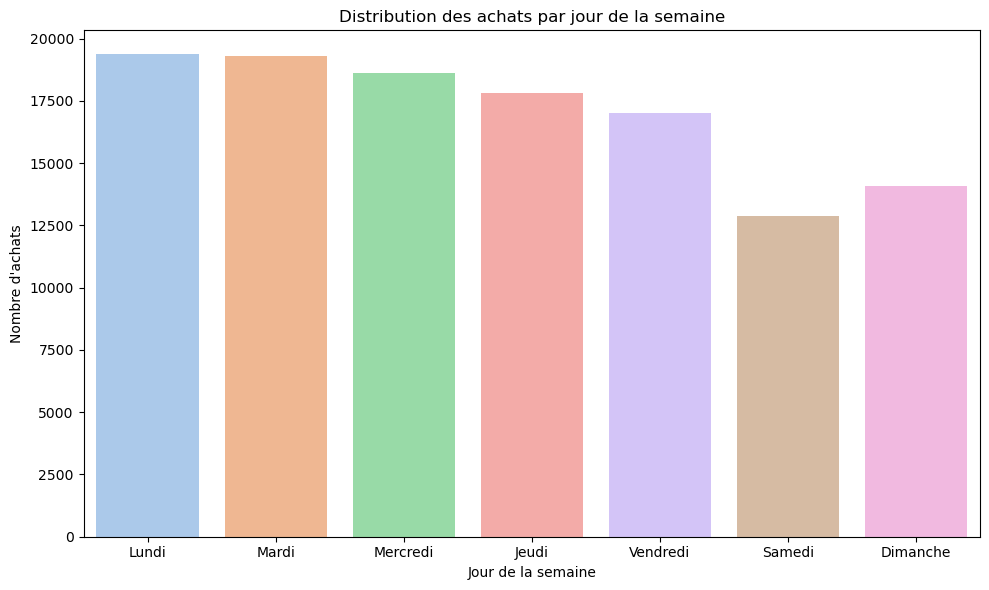

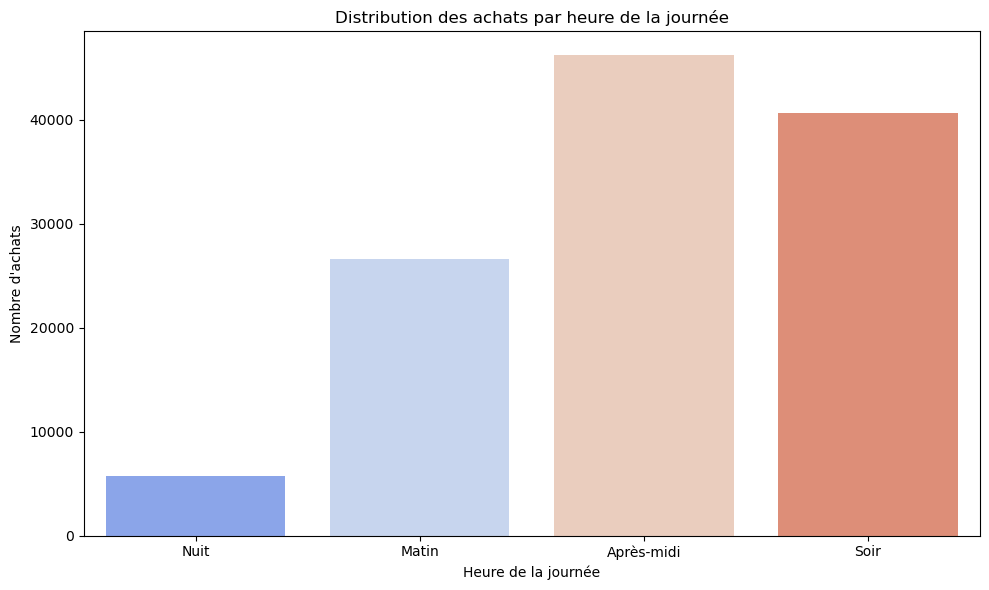

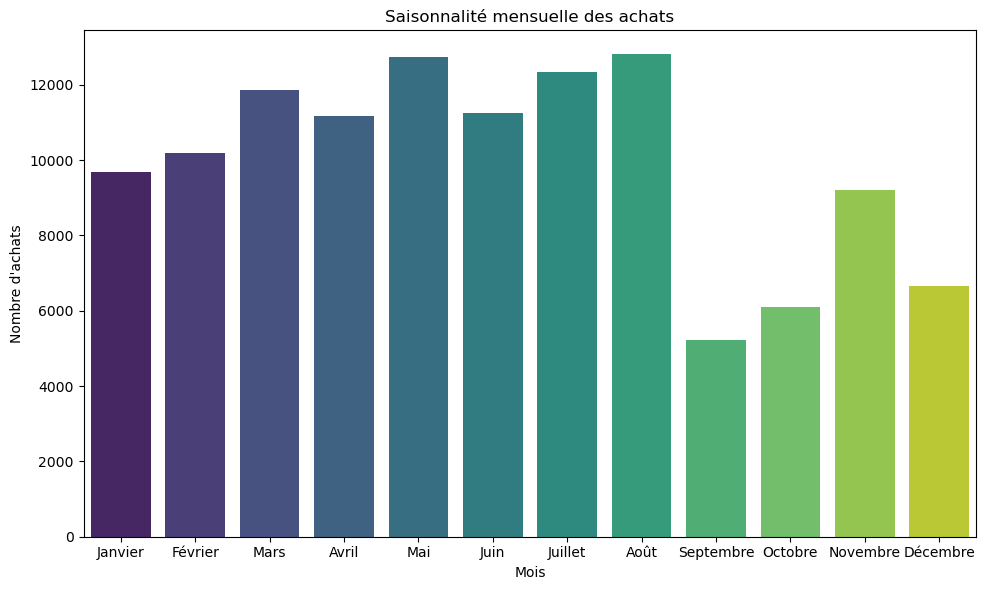

In [111]:
def visualiser_distributions(clustering_data):
    # Visualiser la distribution par jour de la semaine
    plt.figure(figsize=(10, 6))
    jours_semaine = ['day_' + str(i) for i in range(7)]
    if all(jour in clustering_data.columns for jour in jours_semaine):
        jours_data = clustering_data[jours_semaine].sum().reset_index()
        jours_data.columns = ['Jour', 'Nombre d\'achats']
        jours_data['Jour'] = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
        sns.barplot(x='Jour', y='Nombre d\'achats', data=jours_data, palette='pastel')
        plt.title('Distribution des achats par jour de la semaine')
        plt.xlabel('Jour de la semaine')
        plt.ylabel('Nombre d\'achats')
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print("Les colonnes pour les jours de la semaine n'existent pas dans les données.")

    # Visualiser la distribution par heure de la journée
    plt.figure(figsize=(10, 6))
    heures_journee = ['hour_night', 'hour_morning', 'hour_afternoon', 'hour_evening']
    if all(heure in clustering_data.columns for heure in heures_journee):
        heures_data = clustering_data[heures_journee].sum().reset_index()
        heures_data.columns = ['Heure', 'Nombre d\'achats']
        heures_data['Heure'] = ['Nuit', 'Matin', 'Après-midi', 'Soir']
        sns.barplot(x='Heure', y='Nombre d\'achats', data=heures_data, palette='coolwarm')
        plt.title('Distribution des achats par heure de la journée')
        plt.xlabel('Heure de la journée')
        plt.ylabel('Nombre d\'achats')
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print("Les colonnes pour les heures de la journée n'existent pas dans les données.")

    # Visualiser la saisonnalité mensuelle
    plt.figure(figsize=(10, 6))
    mois = ['month_' + str(i) for i in range(1, 13)]
    if all(mois_col in clustering_data.columns for mois_col in mois):
        mois_data = clustering_data[mois].sum().reset_index()
        mois_data.columns = ['Mois', 'Nombre d\'achats']
        mois_data['Mois'] = [
            'Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin',
            'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre'
        ]
        sns.barplot(x='Mois', y='Nombre d\'achats', data=mois_data, palette='viridis')
        plt.title('Saisonnalité mensuelle des achats')
        plt.xlabel('Mois')
        plt.ylabel('Nombre d\'achats')
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print("Les colonnes pour les mois n'existent pas dans les données.")

# Utilisation de la fonction
visualiser_distributions(clustering_data)


Visualisation des distributions temporelles des achats (jours de la semaine, heures de la journée, mois), permettant d'identifier les préférences temporelles globales des clients d'Olist et les potentielles opportunités d'optimisation marketing.

In [112]:
print(clustering_data.columns)

Index(['recence_scaled', 'frequence_scaled', 'montant_scaled',
       'avg_review_log_std', 'avg_product_price_log_std',
       'avg_basket_items_log_std', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'hour_night', 'hour_morning', 'hour_afternoon',
       'hour_evening', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'avg_delivery_time_log_std', 'freight_ratio_std',
       'avg_distance_km_log_std'],
      dtype='object')


Affichage de la liste complète des colonnes du dataset final, fournissant une vue d'ensemble des features disponibles pour le clustering et l'analyse des segments.

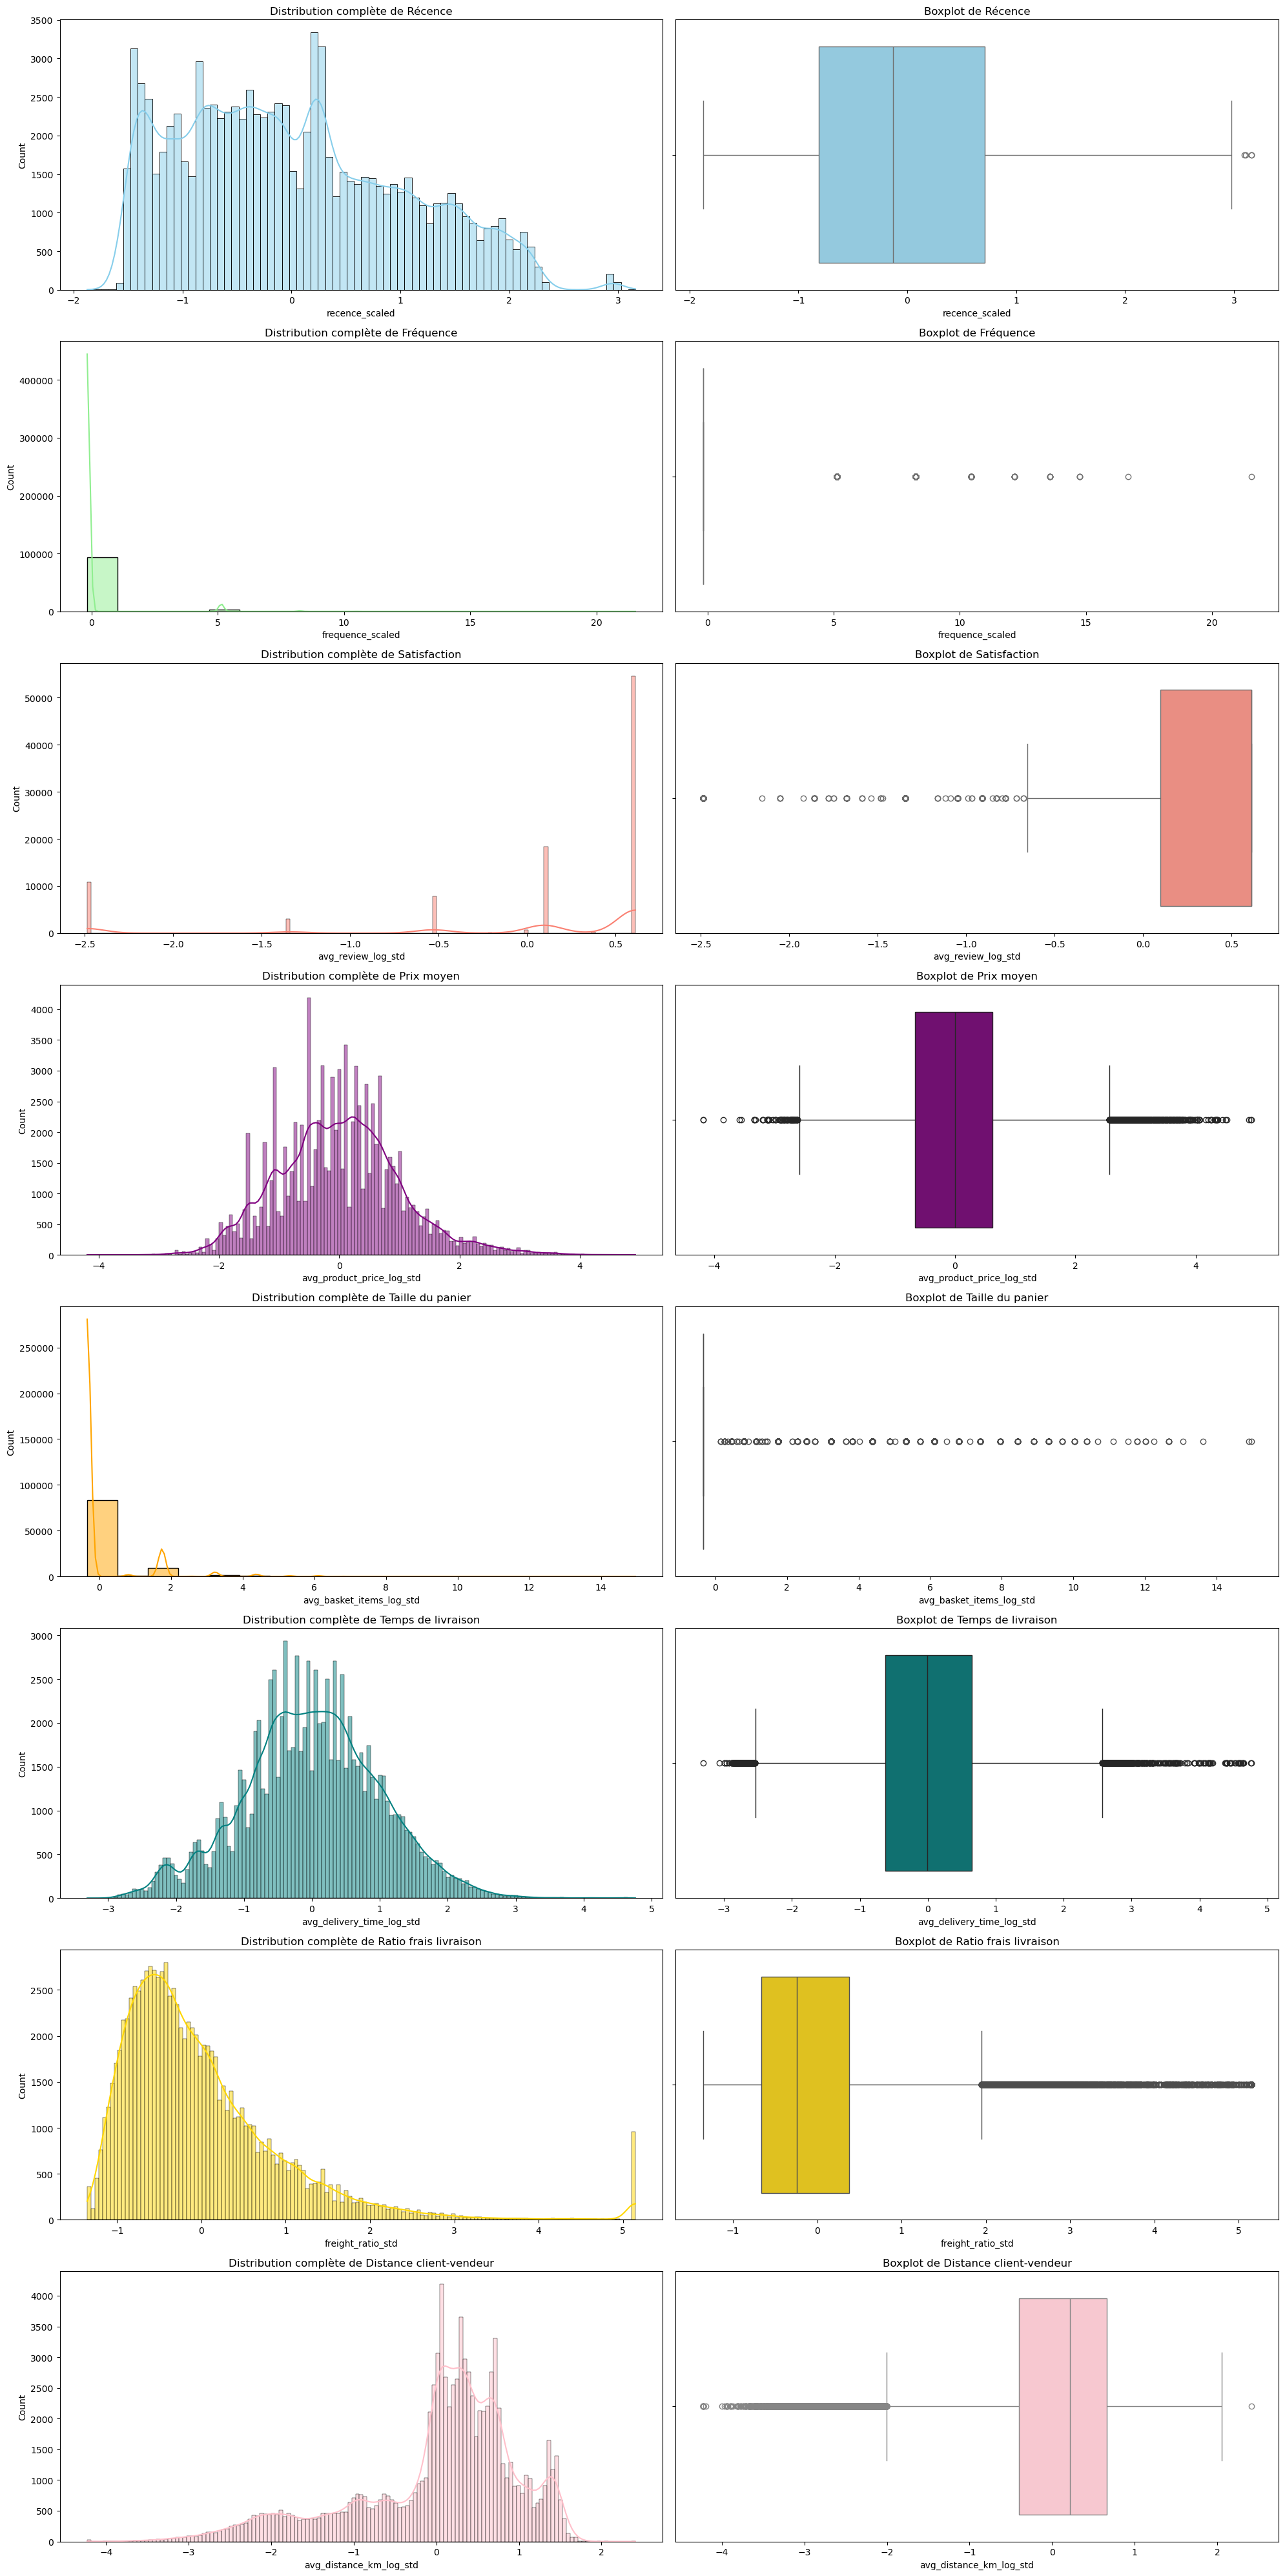

In [113]:
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualiser_features(clustering_data):
    # Définir toutes les métriques transformées et leurs titres
    metrics = [
        ('recence_scaled', 'Récence'),
        ('frequence_scaled', 'Fréquence'),
        ('avg_review_log_std', 'Satisfaction'),
        ('avg_product_price_log_std', 'Prix moyen'),
        ('avg_basket_items_log_std', 'Taille du panier'),
        ('avg_delivery_time_log_std', 'Temps de livraison'),
        ('freight_ratio_std', 'Ratio frais livraison'),
        ('avg_distance_km_log_std', 'Distance client-vendeur')
    ]
    
    # Couleurs pour les graphiques
    colors = ['skyblue', 'lightgreen', 'salmon', 'purple', 'orange', 'teal', 'gold', 'pink']
    
    # Créer les graphiques pour chaque métrique transformée
    # Nombre de lignes adapté au nombre de métriques
    fig, axes = plt.subplots(len(metrics), 2, figsize=(20, 5*len(metrics)))
    
    for i, (metric, title) in enumerate(metrics):
        try:
            if metric in clustering_data.columns:
                # Utiliser toutes les données
                data = clustering_data[metric].dropna()
                
                # Histogramme - Données complètes
                sns.histplot(data, kde=True, ax=axes[i, 0], color=colors[i % len(colors)])
                axes[i, 0].set_title(f'Distribution complète de {title}')
                axes[i, 0].set_xlabel(metric)
                
                # Boxplot - Données complètes
                sns.boxplot(x=data, ax=axes[i, 1], color=colors[i % len(colors)])
                axes[i, 1].set_title(f'Boxplot de {title}')
                axes[i, 1].set_xlabel(metric)
        
        except Exception as e:
            print(f"Erreur pour la métrique {metric}: {e}")
    
    plt.tight_layout()
    plt.show()
    plt.close()

# Utilisation
visualiser_features(clustering_data)

Visualisation complète des distributions de toutes les features transformées utilisées pour le clustering, avec histogrammes et boxplots pour chaque variable, fournissant une compréhension approfondie des données d'entrée du modèle.

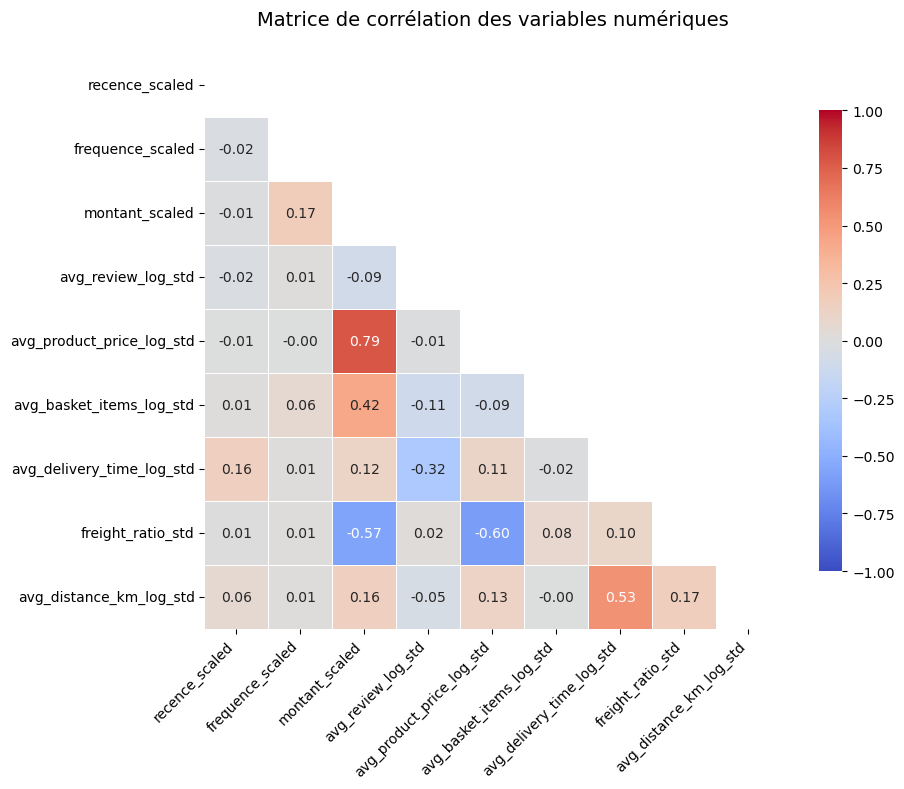

In [114]:
def visualiser_correlation_numerique(clustering_data):
    # Liste des métriques numériques à inclure dans le heatmap
    numeric_metrics = [
        'recence_scaled',
        'frequence_scaled',
        'montant_scaled',
        'avg_review_log_std',
        'avg_product_price_log_std',
        'avg_basket_items_log_std',
        'avg_delivery_time_log_std',
        'freight_ratio_std',
        'avg_distance_km_log_std'
    ]

    # Filtrer le DataFrame pour ne garder que les colonnes numériques spécifiées
    numeric_data = clustering_data[numeric_metrics]

    # Calculer la matrice de corrélation pour les variables numériques
    corr_matrix = numeric_data.corr()

    # Créer une figure avec une taille appropriée
    plt.figure(figsize=(10, 8))

    # Créer un masque pour le triangle supérieur (optionnel, pour éviter la redondance)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Heatmap avec des annotations
    sns.heatmap(corr_matrix,
                annot=True,        # Afficher les valeurs
                fmt='.2f',         # Format à 2 décimales
                cmap='coolwarm',   # Palette de couleurs
                mask=mask,         # Masque pour triangle supérieur
                vmin=-1, vmax=1,   # Échelle de valeurs
                center=0,          # Centrer le colormap à 0
                square=True,       # Cellules carrées
                linewidths=0.5,    # Largeur des lignes de séparation
                cbar_kws={"shrink": .8})  # Réduire la barre de couleur

    # Ajuster les étiquettes pour plus de lisibilité
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Titre
    plt.title('Matrice de corrélation des variables numériques', fontsize=14, pad=20)

    # Sauvegarder
    plt.tight_layout()


    # Afficher
    plt.show()
    plt.close()
    
# Utilisation de la fonction
visualiser_correlation_numerique(clustering_data)


Analyse des corrélations entre les variables numériques utilisées pour le clustering, permettant d'identifier les redondances potentielles et de comprendre les relations entre les différentes dimensions du comportement client.

In [115]:
# Supprimer les variables fortement corrélées
clustering_data = clustering_data.drop(columns=['montant_scaled'])

Élimination de la variable "montant_scaled" fortement corrélée avec d'autres métriques, optimisant le modèle en réduisant la redondance et évitant de surpondérer certaines dimensions comportementales.

In [116]:
print(clustering_data.columns)

Index(['recence_scaled', 'frequence_scaled', 'avg_review_log_std',
       'avg_product_price_log_std', 'avg_basket_items_log_std', 'day_0',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_night',
       'hour_morning', 'hour_afternoon', 'hour_evening', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12',
       'avg_delivery_time_log_std', 'freight_ratio_std',
       'avg_distance_km_log_std'],
      dtype='object')


Vérification finale des colonnes du dataset prêt pour le clustering, confirmant la suppression de la variable redondante et la disponibilité de toutes les features nécessaires.

### Préparation des données pour le clustering

In [117]:
# Examiner le dataframe final
print("\nFinal clustering data - first 5 rows:")
print(clustering_data.head())
print("\nFinal clustering data - shape:")
print(clustering_data.shape)

# Sauvegarde du dataframe pour l'étape suivante (clustering)
clustering_data.to_csv('clustering_data_for_clustering.csv', index=True)



Final clustering data - first 5 rows:
                                  recence_scaled  frequence_scaled  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2       -0.832621         -0.175643   
0000b849f77a49e4a4ce2b2a4ca5be3f       -0.813067         -0.175643   
0000f46a3911fa3c0805444483337064        1.937662         -0.175643   
0000f6ccb0745a6a4b88665a16c9f078        0.529706         -0.175643   
0004aac84e0df4da2b147fca70cf8255        0.314602         -0.175643   

                                  avg_review_log_std  \
customer_unique_id                                     
0000366f3b9a7992bf8c76cfdf3221e2            0.611839   
0000b849f77a49e4a4ce2b2a4ca5be3f            0.097601   
0000f46a3911fa3c0805444483337064           -0.531775   
0000f6ccb0745a6a4b88665a16c9f078            0.097601   
0004aac84e0df4da2b147fca70cf8255            0.611839   

                                  avg_product_price_log_std  \
customer_uniqu

Examen du dataset final préparé pour l'étape de clustering, présentant un aperçu des premières lignes et les dimensions totales, puis sauvegarde dans un fichier CSV pour utilisation dans l'étape suivante du projet.

2 variables RFM (récence, fréquence)
1 variable de satisfaction
3 variables d'habitudes d'achat (prix, taille panier)
19 variables temporelles (7 jours, 4 périodes de la journée, 12 mois)
3 variables de livraison et géographie

#### Controle par la variance

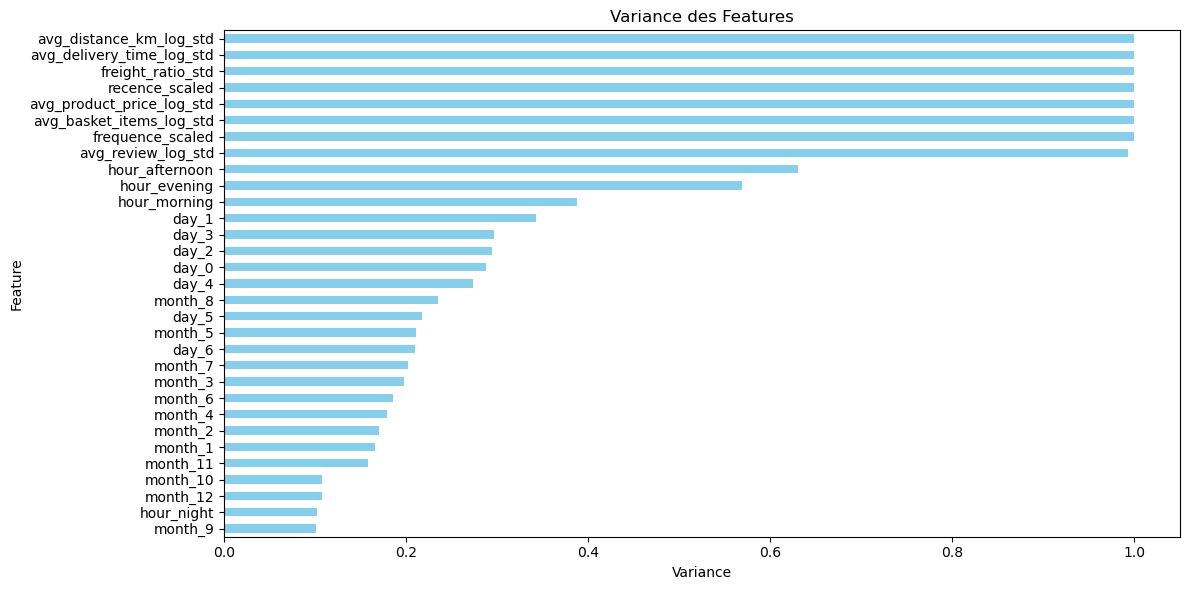

In [118]:
# Calculer la variance de chaque feature
variances = clustering_data.var()

# Visualiser les variances
plt.figure(figsize=(12, 6))
variances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Variance des Features')
plt.xlabel('Variance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
plt.close()

Analyse de la variance de chaque feature pour vérifier leur pouvoir discriminant dans le clustering, les variables standardisées présentant une variance d'environ 1 comme attendu, et les variables catégorielles montrant des variances plus faibles. Cette visualisation permet d'identifier les variables qui contribueront le plus à la différenciation des segments.

Variables avec forte variance (1.0)
- Les variables standardisées (recence_scaled, avg_product_price_log_std, etc.) ont toutes une variance proche de 1(standardisation ok).
- Elles auront un poids important dans votre clustering.


Variables temporelles avec variance moyenne
- hour_afternoon (0.6) est la période de la journée avec la plus grande variance : diversité dans les comportements d'achat l'après-midi ?
- hour_evening et hour_morning (0.4/0.5) présentent également une variance notable.
- Les mardi et jeudi montrent plus de variance que les autres jours.


Variables temporelles avec faible variance
- Le mois et hour_night ont une variance faible (< 0.2)... impact limité sur la segmentation?